In [1]:
## Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections
from datetime import datetime

import folium
from folium.map import *
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import FloatImage
from folium.plugins import MarkerCluster

import statsmodels.api as sm
import sklearn
import sklearn.model_selection

import seaborn as sns 

In [2]:
## Normalize columns of pd.DataFrame
def norm_df(dfx):
    dft1 = pd.DataFrame()
    for i in dfx.iteritems():
        norm = (i[1] - np.min(i[1]))/(np.max(i[1]) - np.min(i[1]))
        dft1 = pd.concat([dft1, norm], axis=1)
    return dft1


In [3]:
## outliers_thefts
def outliers_thefts(dfx, th):
    from scipy import stats
    import numpy as np

    z = np.abs(stats.zscore(dfx[th]))
    ix1 = (z <= 1)
    return ix1
    

In [4]:
## DO NOT RUN! - start. Creatation of network
'''
dbXY = pd.read_csv(".//input//CTA_BusStops.csv", sep=",")
dbXY = dbXY.dropna()
dbXY.reset_index(inplace = True) 

G=nx.Graph()
try:
    for index1, row1 in dbXY.iterrows():
        print(str(index1) + ' - ' + str(len(dbXY.POINT_X)))
        b = row1.SYSTEMSTOP
        r = row1.ROUTESSTPG

        n = np.array([row1.POINT_Y, row1.POINT_X])
        m = np.array([dbXY.POINT_Y[index1:], dbXY.POINT_X[index1:]]).T
        p = [geopy.distance.geodesic(n, i).km for i in m]
        ## BS with more than one route in common
        if ',' in r:
            rn = r.split(',')            
            for rni in rn:
                for i in range(0, len(p)):
                    nearBSIdx = p.index(sorted(set(p))[i])
                    # Find the nearest BS with a route in common
                    if (rni in dbXY.ROUTESSTPG[nearBSIdx]) and (dbXY.SYSTEMSTOP[nearBSIdx] != b):
                        G.add_edge(b, dbXY.SYSTEMSTOP[nearBSIdx])
                        break 
        ## BS with one route in common
        else:        
            for i in range(0, len(p)):
                nearBSIdx = p.index(sorted(set(p))[i])
                # Find the nearest BS with a route in common
                if (r in dbXY.ROUTESSTPG[nearBSIdx]) and (dbXY.SYSTEMSTOP[nearBSIdx] != b):
                    G.add_edge(b, dbXY.SYSTEMSTOP[nearBSIdx])
                    break 
except:
    pass

## Filter main component of network
graphs = list(nx.connected_components(G))
list_subgraphs = [items for i in graphs for items in i if len(i) >= 50]
F = G.subgraph(list_subgraphs)
pdF = nx.to_pandas_edgelist(F)
pdF.to_csv('raw_net.csv')
## Creatation of network
## DO NOT RUN! - end
'''


'\ndbXY = pd.read_csv(".//input//CTA_BusStops.csv", sep=",")\ndbXY = dbXY.dropna()\ndbXY.reset_index(inplace = True) \n\nG=nx.Graph()\ntry:\n    for index1, row1 in dbXY.iterrows():\n        print(str(index1) + \' - \' + str(len(dbXY.POINT_X)))\n        b = row1.SYSTEMSTOP\n        r = row1.ROUTESSTPG\n\n        n = np.array([row1.POINT_Y, row1.POINT_X])\n        m = np.array([dbXY.POINT_Y[index1:], dbXY.POINT_X[index1:]]).T\n        p = [geopy.distance.geodesic(n, i).km for i in m]\n        ## BS with more than one route in common\n        if \',\' in r:\n            rn = r.split(\',\')            \n            for rni in rn:\n                for i in range(0, len(p)):\n                    nearBSIdx = p.index(sorted(set(p))[i])\n                    # Find the nearest BS with a route in common\n                    if (rni in dbXY.ROUTESSTPG[nearBSIdx]) and (dbXY.SYSTEMSTOP[nearBSIdx] != b):\n                        G.add_edge(b, dbXY.SYSTEMSTOP[nearBSIdx])\n                        brea

In [5]:
## Load full network dataset
dbF = pd.read_csv(".//input//raw_net.csv", sep=",")
dbF.columns = ['', 'source', 'target']
del dbF['']
F = nx.from_pandas_edgelist(dbF, 'source', 'target')
nx.info(F);

In [6]:
## Compute network properties
df = pd.DataFrame(dict(
    degree = dict(F.degree),
    degree_centrality = nx.degree_centrality(F),
    closeness_centrality = nx.closeness_centrality(F),
    betweenness_centrality = nx.betweenness_centrality(F),
    clustcoef = nx.clustering(F),
    adjtri = nx.triangles(F),
    ecc = nx.eccentricity(F),
    pg = nx.pagerank(F),
)) 
df.index.names = ['stop_id'];


In [7]:
## Load bus stop geo-positions dataset
dbXY = pd.read_csv(".//input//CTA_BusStops.csv", sep=",")
dbXY = dbXY.dropna()
dbXY.reset_index(inplace = True) 


In [8]:
## Rename column SYSTEMSTOP for stop_id bus stop geo-positions dataset
dbXY.rename(columns={'SYSTEMSTOP':'stop_id'}, inplace=True)
dbXY = dbXY.set_index('stop_id')
dbXY = dbXY.sort_index()


In [9]:
## Load 'boardings', 'alightings' of each bus stop dataset
dbRT = pd.read_csv(".//input//CTA_-_Ridership_-_Avg._Weekday_Bus_Stop_Boardings_in_October_2012.csv",
                   sep=",", decimal=",")


In [10]:
## Match and organize the 'boardings', 'alightings' with bus stops

## Remove nodes without boardings and aligthings
columns = ['boardings', 'alightings']
t = pd.DataFrame(columns=columns)
for i in list(F):
    idx = dbRT.index[dbRT.stop_id == i].tolist()
    if dbRT['boardings'][idx].empty:
        F.remove_node(i)

columns = ['stop_id', 'boardings', 'alightings']
t = pd.DataFrame(columns=columns)
for i in list(F):
    idx = dbRT.index[dbRT.stop_id == i].tolist()
    n = dbRT['boardings'][idx].values[0]
    m = dbRT['alightings'][idx].values[0]
    n = float(n.replace(",", ""))
    m = float(m.replace(",", ""))
    t.loc[len(t)] = [i, n, m]
t = t.set_index('stop_id')
t = t.sort_index()


In [11]:
## Merge 'boardings', 'alightings' and network properties of each bus stop
df = df.sort_index()
t = t.sort_index()
df1 = pd.merge(df, t, on='stop_id')
df1 = df1.apply(pd.to_numeric)


In [12]:
## Load thefts locations.
## Join dataset

def loaddbTH():
    # prefix = ".//input//Crimes_2001_csvs//Crimes_2001_csv_"
    prefix = ".//input//db_thefts_"
    cf = 1
    # parts = 70
    parts = 25

    for cf in range(0, parts):
        tmp = pd.read_csv(prefix + str(cf + 1) + ".csv") 
        if cf == 0:
            db2 = tmp
        else:
            tmp = [db2, tmp]
            db2 = pd.concat(tmp)
        del tmp
    db2 = db2.set_index('Date')
    return db2
dbTH = loaddbTH()

In [13]:
## Merge 'boardings', 'alightings', network properties and thefts of each bus stop
def prepare_df2(th, db2, df1):
    
    ## Initialization of variables for main dataset - association of thefts to BS
    lat = dbXY.loc[df1.index.values].POINT_Y.values
    lon = dbXY.loc[df1.index.values].POINT_X.values
    cLat = (0.0000068)*397
    cLon = (0.000009)*397
    types = ['$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
           'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
           'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT']
    
    t1 = pd.DataFrame(columns=types)   
    
    ## Association of thefts to BS
    for i in range(0, len(df1)):
        point = [lat[i], lon[i]]
        db3 = db2[(db2.Latitude <= (point[0] + cLat)).values
              & (db2.Latitude >= (point[0] - cLat)).values
              & (db2.Longitude >= (point[1] - cLon)).values
              & (db2.Longitude <= (point[1] + cLon)).values]
        
        byType = [np.sum(db3.Description == i) for i in types]

        t1.loc[len(t1)] = byType

    t1 = t1.set_index([pd.Index(df1.index)])
    t1.index.names = ['stop_id']
    
    ## Merge 'boardings', 'alightings', network properties and thefts of each bus stop
    df2 = pd.merge(df1, t1, on='stop_id')
    df2 = df2.apply(pd.to_numeric)
    df2.dtypes
    df2.to_csv('dataset_final.csv')
    return df2


In [14]:
## Create OLS model
def compute_ols(train, th):  
    X =  train.drop([th], axis=1)
    X_constant = sm.add_constant(X)
    
    y = train[th]
    
    olsmod = sm.OLS(y, X_constant)
    olsres = olsmod.fit()
    return olsres  


In [15]:
## Equal variance of residuals (Homoscedasticity - test 1)
def Homoscedasticity_test1(olsres, test, q, th):
    
    # Graphic test 
    ## Compute predictions and residuals
    fitted_vals = olsres.predict()
    resids = olsres.resid
    Xnew = test.drop([th], axis=1)
    X_constant1 = sm.add_constant(Xnew)
    y_true = test[th]
    ynewpred =  olsres.predict(X_constant1)
    
    ## Set params of plots
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "24"
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    ## Init plots
    colors = ['#2300A8', '#009058']
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ### Plot 0. residuals and data
    ax[0].scatter(
        x=fitted_vals, 
        y=resids, 
        label="Data", 
        alpha=0.50, 
        color=colors[1])
    ### Plot 0. Configurations
    ax[0].set_title(th)
    ax[0].set(
        xlabel='Fitted Values', 
        ylabel='Residuals')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ### Plot 1. predicted and data
    ax[1].scatter(
        y=ynewpred, 
        x=y_true, 
        label="Data", 
        alpha=0.50, 
        color=colors[1])
    ### Plot 1. diagonal line    
    ax[1].plot(
        [y_true.min(), y_true.max()], 
        [y_true.min(), y_true.max()], 
        'gray', lw=1)  
    ### Plot 1. confidence band
    xplt = np.linspace(y_true.min(), y_true.max(), 1000)
    ax[1].fill_between(
        xplt, 
        xplt-np.std(xplt), 
        xplt+np.std(xplt),
        color='gray', alpha=0.2)    
    ### Plot 1. Configurations
    ax[1].set_title(q)
    ax[1].set_xlabel('Observations')
    ax[1].set_ylabel('Predictions')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].set_title(
        '$R^2$=' + str(np.round(olsres.rsquared_adj, 2)) + 
        '\t$SD$=' + str(np.round(np.std(y_true.values),2)) +
        '\tQ=' + str(q+1))
    plt.show()  
    
    
    ## Analytic test - Chi squared
    from scipy.stats import chisquare
    
    degFree = len(test.columns)-1
    dfChi = pd.read_csv(".//input//chisqtab.csv", sep=";")
    dfChi = dfChi.set_index('degFree')
    xc = chisquare(ynewpred, ddof=degFree)[0]
    xt = dfChi.iloc[degFree]['.05']
    # if xt < xc ---> Ha else ---> Ho
    if xt >= xc:
        print('Ho null hypothesis')
    else:
        print('Ha alternative hypothesis')
    print('chi2 =' + str(xc))
    print('chi2Table =' + str(xt))
    
    # Print parameters of model
    print('Equation coefficients')
    print(olsres.params)
    
    return fitted_vals


In [16]:
## Uncorrelated features and residuals (Multicollinearity - test 2)
def Multicollinearity_test2(train, th):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = train.drop([th], axis=1)
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif[:]}, index=X.columns))

In [17]:
## No auto-correlation of residuals (test 3)
def NoAutoCorrelation_test3(fitted_vals):
    import statsmodels.tsa.api as smt

    N, M = 12, 6
    fig, ax = plt.subplots(figsize=(N, M))
    smt.graphics.plot_pacf(fitted_vals, lags = 15, title=' ', ax=ax)
    ax.set_ylim(-0.15, 0.25)
    ax.set_xlim(0.5, 16)
    plt.show()

################################################################
$500 AND UNDER
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[ 347. ]
 [ 529.5]
 [ 714. ]
 [1234. ]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


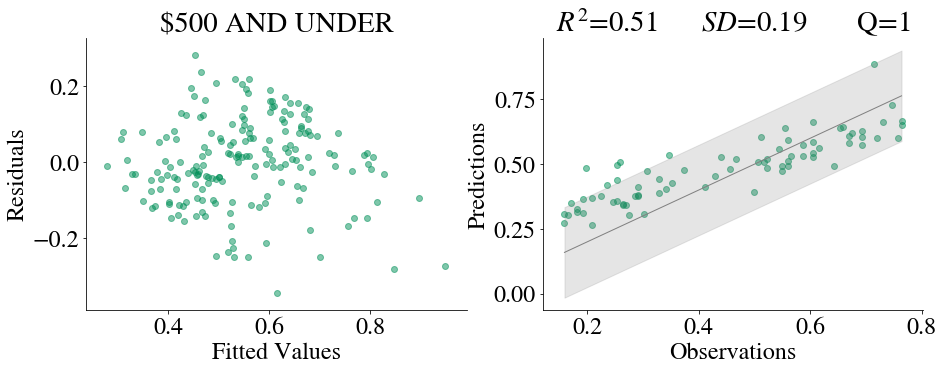

Ho null hypothesis
chi2 =2.362678476165222
chi2Table =26.3
Equation coefficients
const                            -1.028511
degree                            0.029231
closeness_centrality              0.001962
betweenness_centrality            0.196162
boardings                        -0.103613
alightings                        0.039127
L                                 1.861831
C                                 1.102673
ATTEMPT THEFT                     0.204467
FINANCIAL ID THEFT: OVER $300     0.221276
FINANCIAL ID THEFT:$300 &UNDER    0.059535
FROM BUILDING                     0.961117
OVER $500                         0.982646
POCKET-PICKING                    0.275017
PURSE-SNATCHING                   0.307039
RETAIL THEFT                      1.103331
dtype: float64
                                      vif
degree                           3.387086
closeness_centrality            14.827901
betweenness_centrality           2.697861
boardings                        2.504343
alight

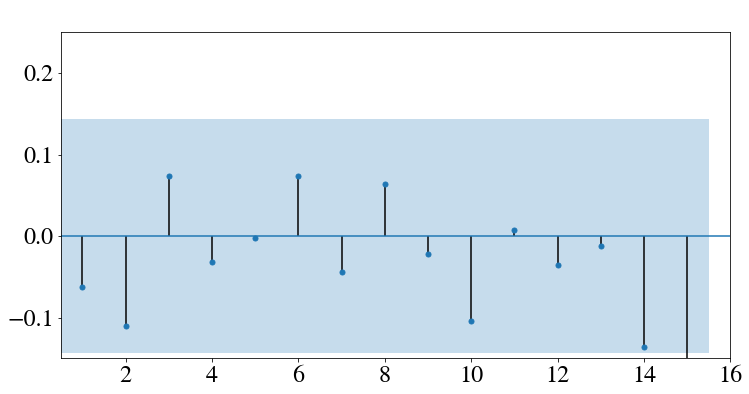

$500 AND UNDER Q=1
################################################################


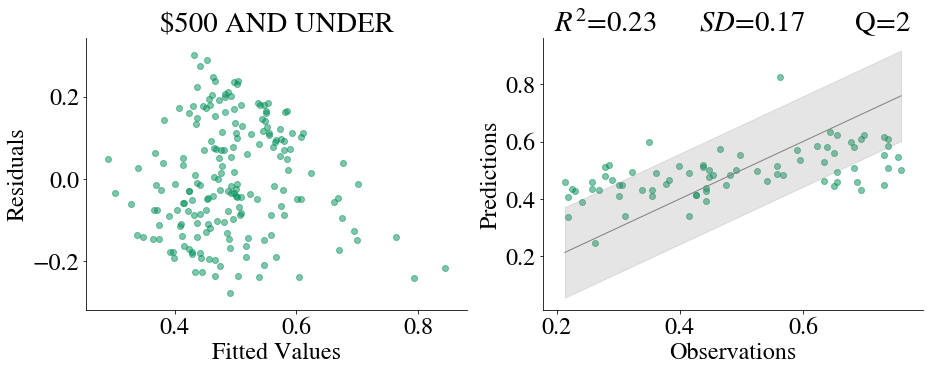

Ho null hypothesis
chi2 =1.0878140596054953
chi2Table =26.3
Equation coefficients
const                            -0.530997
degree                           -0.186482
closeness_centrality              0.095631
betweenness_centrality            0.071344
boardings                        -0.049078
alightings                        0.117798
L                                 0.823275
C                                 0.208711
ATTEMPT THEFT                     0.160781
FINANCIAL ID THEFT: OVER $300     0.168277
FINANCIAL ID THEFT:$300 &UNDER   -0.032093
FROM BUILDING                     0.480306
OVER $500                         0.718270
POCKET-PICKING                    0.034048
PURSE-SNATCHING                   0.353245
RETAIL THEFT                      0.555865
dtype: float64
                                      vif
degree                           2.666082
closeness_centrality            12.487573
betweenness_centrality           2.221658
boardings                        3.030713
aligh

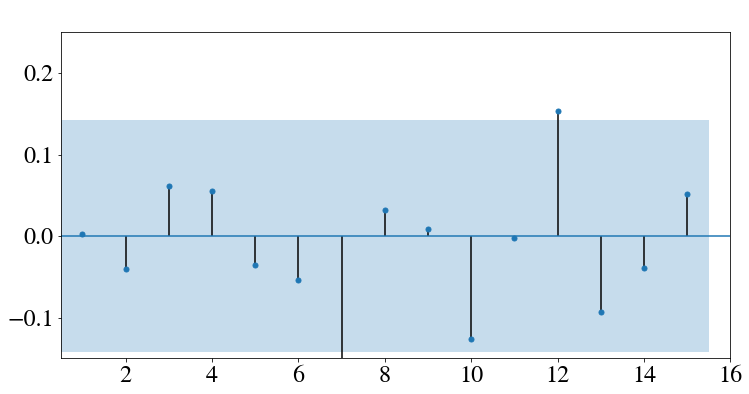

$500 AND UNDER Q=2
################################################################


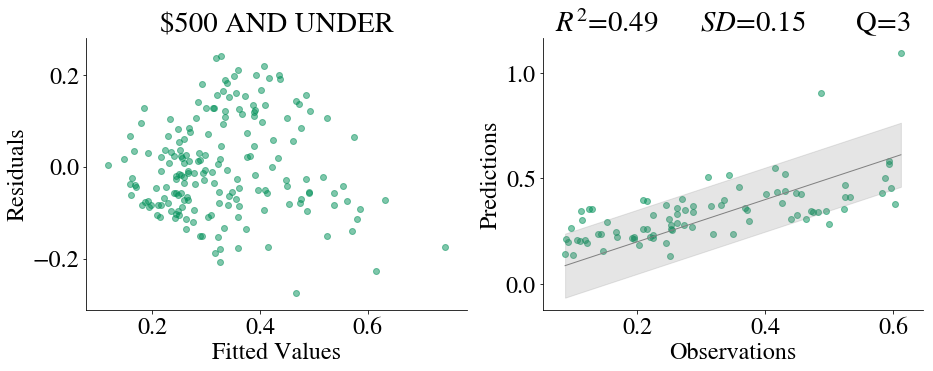

Ho null hypothesis
chi2 =5.315409759784445
chi2Table =26.3
Equation coefficients
const                            -0.421442
degree                           -0.100664
closeness_centrality             -0.016127
betweenness_centrality            0.056257
boardings                         0.117351
alightings                        0.039539
L                                 0.450011
C                                 0.201967
ATTEMPT THEFT                    -0.014047
FINANCIAL ID THEFT: OVER $300    -0.038711
FINANCIAL ID THEFT:$300 &UNDER    0.270638
FROM BUILDING                     0.423955
OVER $500                         0.854626
POCKET-PICKING                    0.146379
PURSE-SNATCHING                   0.465782
RETAIL THEFT                      0.696385
dtype: float64
                                      vif
degree                           4.349856
closeness_centrality            14.774906
betweenness_centrality           4.022563
boardings                        2.818735
alight

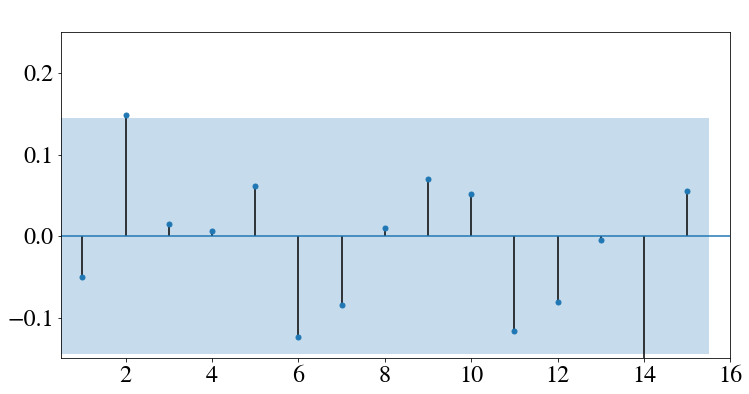

$500 AND UNDER Q=3
################################################################


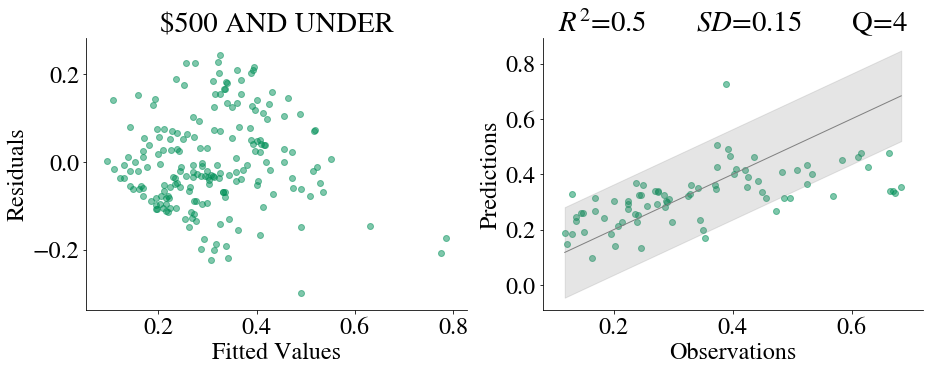

Ho null hypothesis
chi2 =2.515060038449324
chi2Table =26.3
Equation coefficients
const                            -0.439218
degree                            0.073405
closeness_centrality             -0.060252
betweenness_centrality           -0.332133
boardings                         0.122109
alightings                        0.024262
L                                 0.517561
C                                 0.108412
ATTEMPT THEFT                     0.123737
FINANCIAL ID THEFT: OVER $300    -0.062993
FINANCIAL ID THEFT:$300 &UNDER    0.308501
FROM BUILDING                     0.068434
OVER $500                         0.859619
POCKET-PICKING                    0.143825
PURSE-SNATCHING                   0.380145
RETAIL THEFT                      0.846559
dtype: float64
                                      vif
degree                           4.111414
closeness_centrality            13.329923
betweenness_centrality           3.492936
boardings                        3.533823
alight

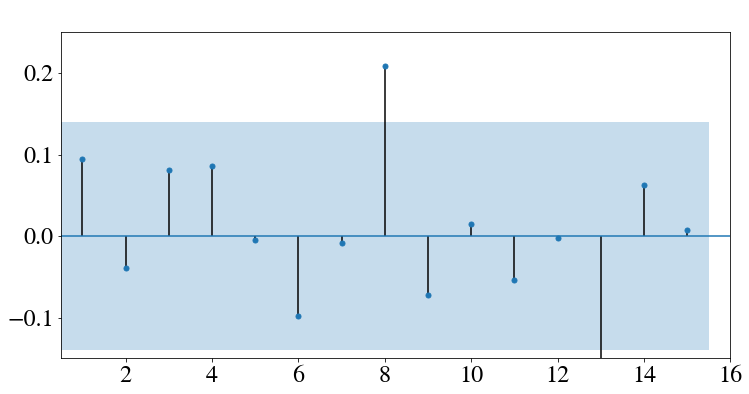

$500 AND UNDER Q=4
################################################################
################################################################
ATTEMPT THEFT
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[ 6. ]
 [ 9.5]
 [15. ]
 [38. ]]


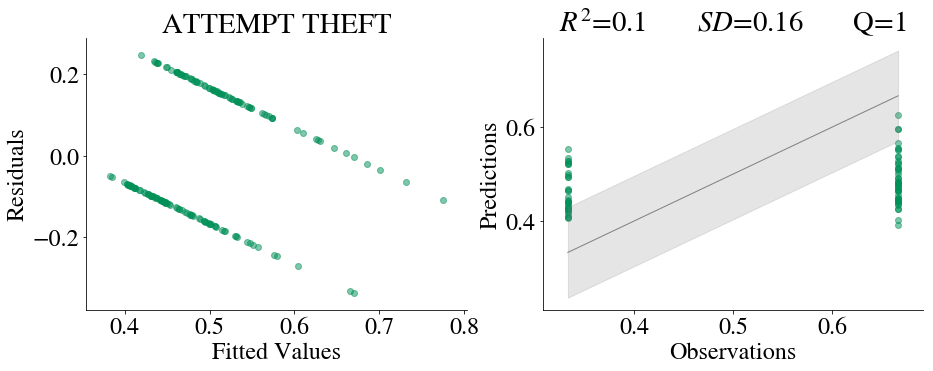

Ho null hypothesis
chi2 =0.40131386245902834
chi2Table =26.3
Equation coefficients
const                             0.056942
degree                            0.132677
closeness_centrality              0.042647
betweenness_centrality            0.109543
boardings                         0.175791
alightings                       -0.117759
L                                 0.572612
C                                -0.205884
$500 AND UNDER                    0.323365
FINANCIAL ID THEFT: OVER $300    -0.088494
FINANCIAL ID THEFT:$300 &UNDER    0.074520
FROM BUILDING                     0.152605
OVER $500                         0.317579
POCKET-PICKING                    0.012620
PURSE-SNATCHING                  -0.030210
RETAIL THEFT                      0.324226
dtype: float64
                                      vif
degree                           3.786285
closeness_centrality            11.435737
betweenness_centrality           3.373104
boardings                        3.097894
alig

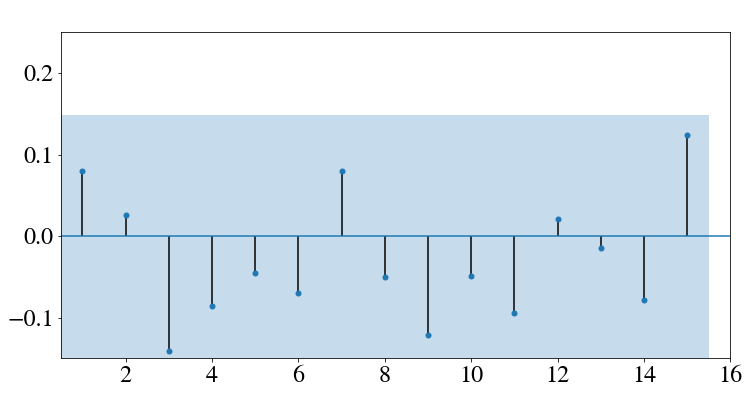

ATTEMPT THEFT Q=1
################################################################


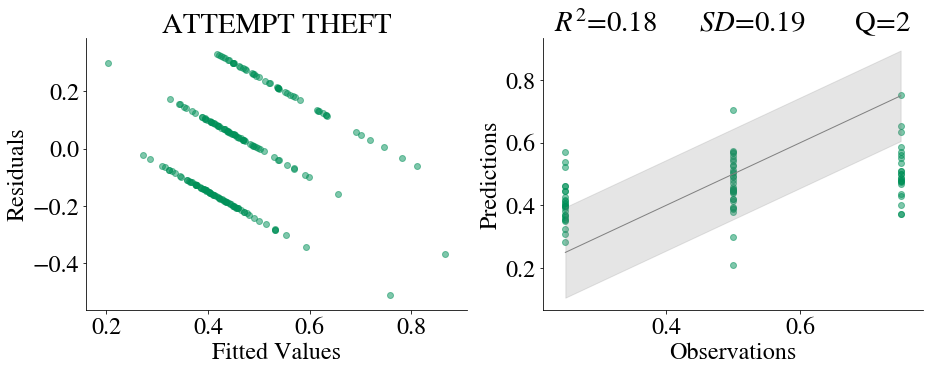

Ho null hypothesis
chi2 =1.4732749284210342
chi2Table =26.3
Equation coefficients
const                            -0.318833
degree                           -1.904185
closeness_centrality              0.048619
betweenness_centrality            0.493323
boardings                        -0.081070
alightings                        0.046053
L                                 1.161064
C                                -0.113852
$500 AND UNDER                    0.631738
FINANCIAL ID THEFT: OVER $300     0.090966
FINANCIAL ID THEFT:$300 &UNDER   -0.059237
FROM BUILDING                     0.253020
OVER $500                         0.031283
POCKET-PICKING                    0.336176
PURSE-SNATCHING                   0.019937
RETAIL THEFT                      0.251148
dtype: float64
                                      vif
degree                           3.075913
closeness_centrality            11.702806
betweenness_centrality           2.260284
boardings                        3.317478
aligh

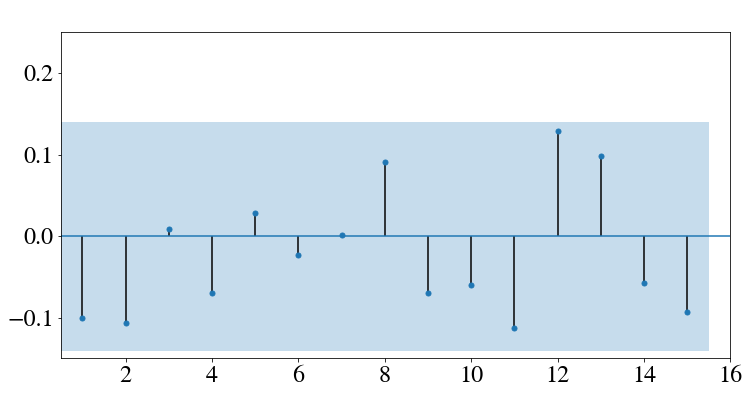

ATTEMPT THEFT Q=2
################################################################


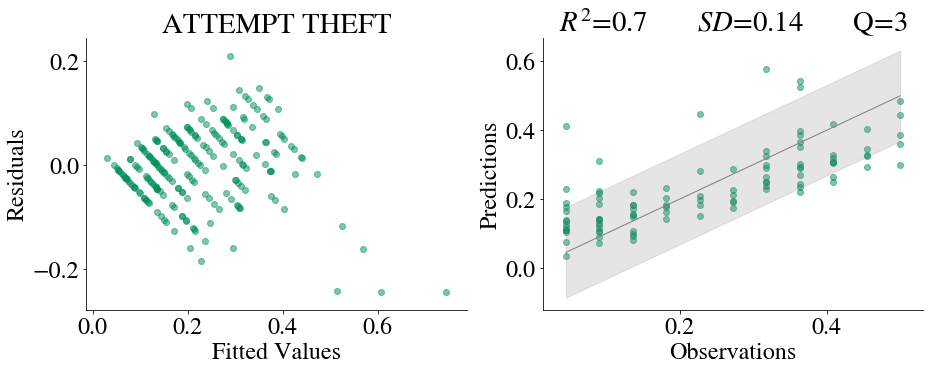

Ho null hypothesis
chi2 =5.22819038809614
chi2Table =26.3
Equation coefficients
const                            -0.515670
degree                            0.075826
closeness_centrality             -0.051444
betweenness_centrality           -0.031141
boardings                        -0.014883
alightings                        0.107623
L                                 1.167775
C                                -0.037982
$500 AND UNDER                    0.547426
FINANCIAL ID THEFT: OVER $300    -0.007475
FINANCIAL ID THEFT:$300 &UNDER   -0.038041
FROM BUILDING                     0.465329
OVER $500                         0.554156
POCKET-PICKING                    0.056116
PURSE-SNATCHING                   0.145014
RETAIL THEFT                      0.868099
dtype: float64
                                      vif
degree                           4.743463
closeness_centrality             9.068653
betweenness_centrality           4.199377
boardings                        2.988948
alighti

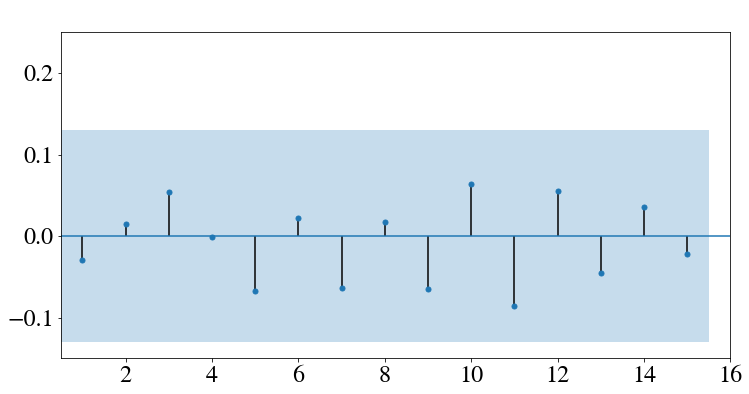

ATTEMPT THEFT Q=3
################################################################


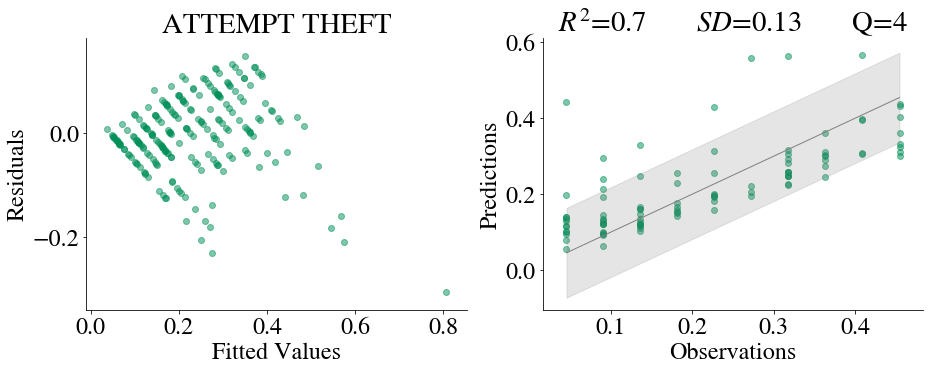

Ho null hypothesis
chi2 =5.526126258382265
chi2Table =26.3
Equation coefficients
const                            -0.553074
degree                           -0.012719
closeness_centrality             -0.027835
betweenness_centrality            0.067831
boardings                         0.052962
alightings                        0.090759
L                                 1.246520
C                                 0.048993
$500 AND UNDER                    0.503788
FINANCIAL ID THEFT: OVER $300    -0.042588
FINANCIAL ID THEFT:$300 &UNDER    0.017939
FROM BUILDING                     0.642489
OVER $500                         0.504701
POCKET-PICKING                    0.057024
PURSE-SNATCHING                   0.148968
RETAIL THEFT                      0.876907
dtype: float64
                                      vif
degree                           2.585082
closeness_centrality             9.868245
betweenness_centrality           1.954121
boardings                        2.932687
alight

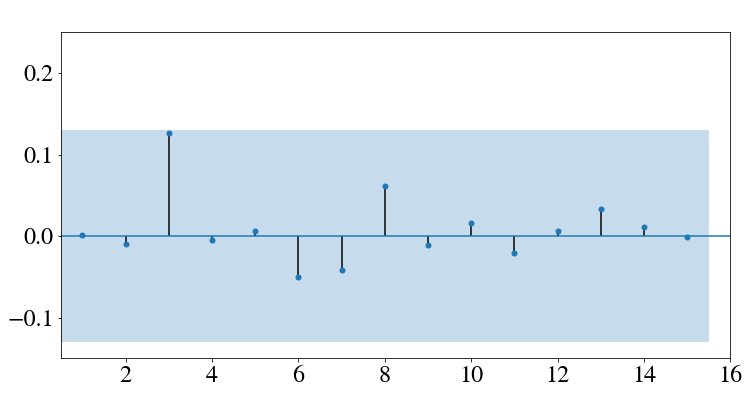

ATTEMPT THEFT Q=4
################################################################
################################################################
FINANCIAL ID THEFT: OVER $300
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[24.]
 [35.]
 [47.]
 [71.]]


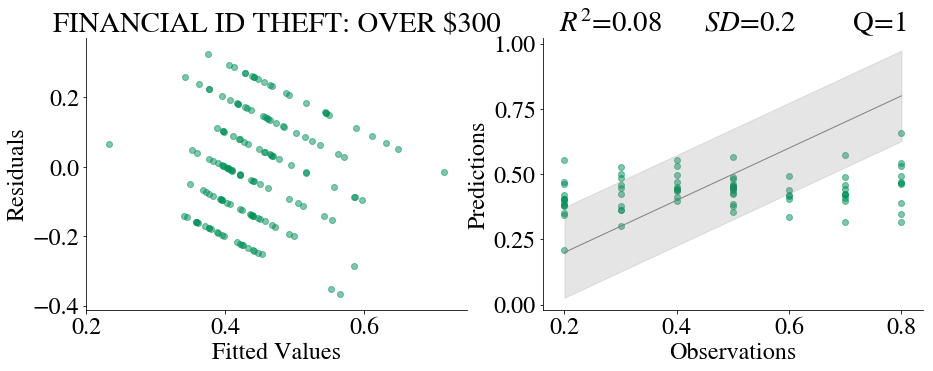

Ho null hypothesis
chi2 =0.8435616848049338
chi2Table =26.3
Equation coefficients
const                             0.120231
degree                           -0.076280
closeness_centrality              0.008312
betweenness_centrality            0.052900
boardings                         0.304035
alightings                       -0.338805
L                                 0.494534
C                                -0.119825
$500 AND UNDER                    0.231952
ATTEMPT THEFT                    -0.267967
FINANCIAL ID THEFT:$300 &UNDER    0.164132
FROM BUILDING                     0.436590
OVER $500                         0.185823
POCKET-PICKING                   -0.207185
PURSE-SNATCHING                   0.270419
RETAIL THEFT                      0.165920
dtype: float64
                                      vif
degree                           6.054764
closeness_centrality            12.804432
betweenness_centrality           4.147716
boardings                        4.348268
aligh

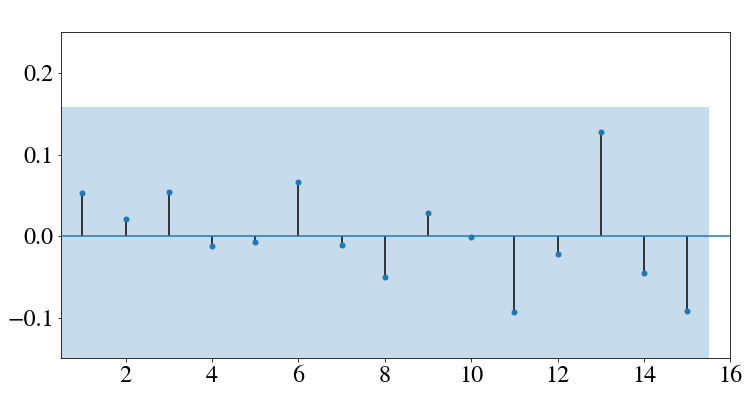

FINANCIAL ID THEFT: OVER $300 Q=1
################################################################


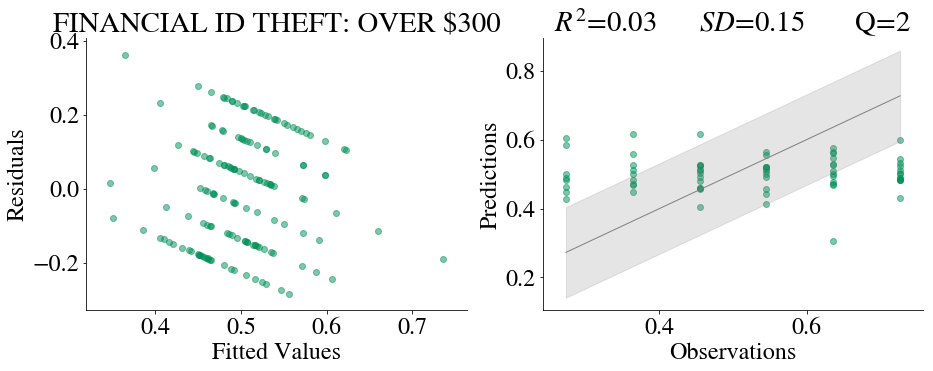

Ho null hypothesis
chi2 =0.35660675972086225
chi2Table =26.3
Equation coefficients
const                             0.273789
degree                            0.377558
closeness_centrality             -0.046032
betweenness_centrality           -0.865258
boardings                         0.008390
alightings                       -0.001930
L                                 0.433060
C                                -0.038880
$500 AND UNDER                    0.128374
ATTEMPT THEFT                     0.045243
FINANCIAL ID THEFT:$300 &UNDER    0.081201
FROM BUILDING                     0.127508
OVER $500                         0.241095
POCKET-PICKING                   -0.146613
PURSE-SNATCHING                  -0.054475
RETAIL THEFT                      0.102143
dtype: float64
                                      vif
degree                           5.340755
closeness_centrality            13.058318
betweenness_centrality           4.343680
boardings                        3.114421
alig

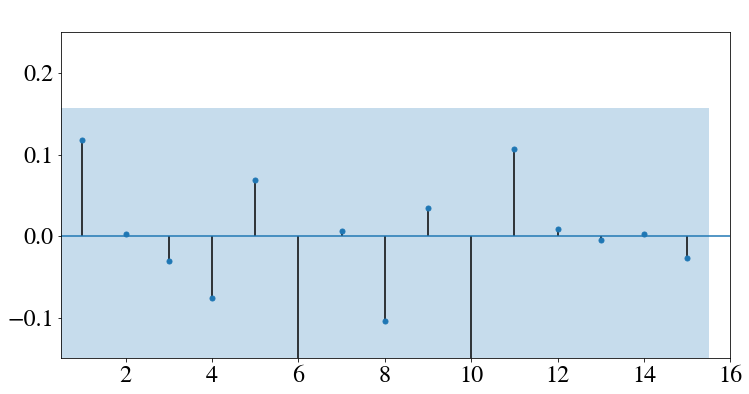

FINANCIAL ID THEFT: OVER $300 Q=2
################################################################


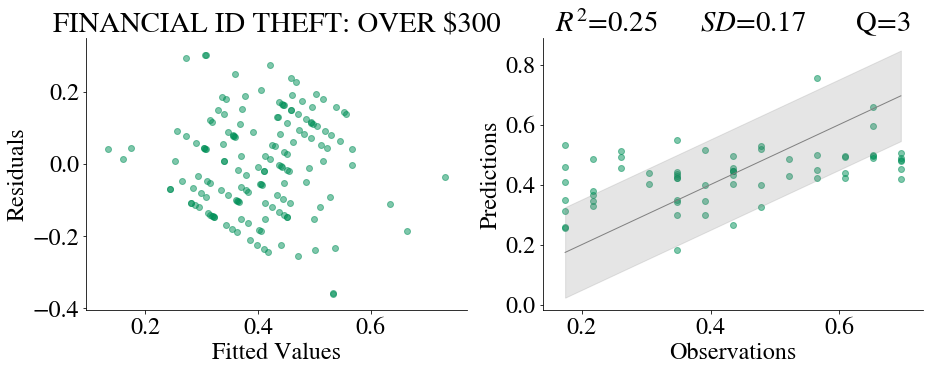

Ho null hypothesis
chi2 =1.2961952864945527
chi2Table =26.3
Equation coefficients
const                            -0.298689
degree                            0.130376
closeness_centrality              0.029091
betweenness_centrality           -0.260560
boardings                         0.036292
alightings                       -0.046839
L                                 0.948672
C                                -0.074646
$500 AND UNDER                    0.544628
ATTEMPT THEFT                     0.147989
FINANCIAL ID THEFT:$300 &UNDER    0.321556
FROM BUILDING                     0.418899
OVER $500                         0.269391
POCKET-PICKING                   -1.048337
PURSE-SNATCHING                   0.255217
RETAIL THEFT                      0.160179
dtype: float64
                                      vif
degree                           4.640126
closeness_centrality            13.145638
betweenness_centrality           4.843841
boardings                        4.506247
aligh

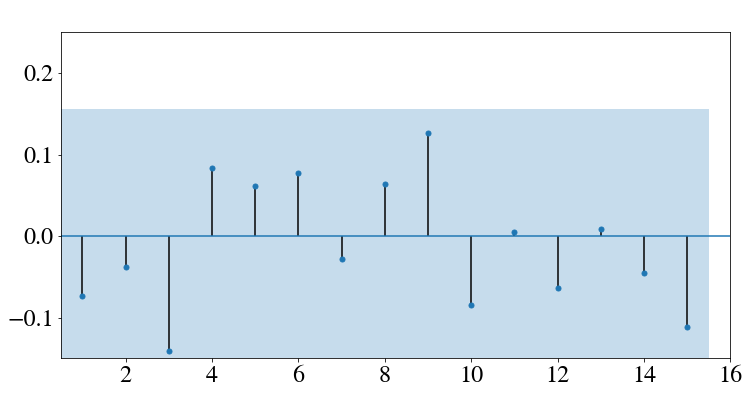

FINANCIAL ID THEFT: OVER $300 Q=3
################################################################


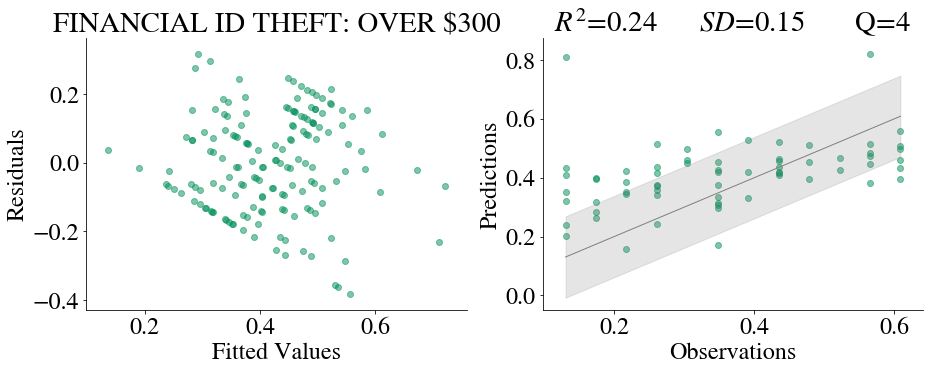

Ho null hypothesis
chi2 =2.0116512160395157
chi2Table =26.3
Equation coefficients
const                            -0.260894
degree                            0.053642
closeness_centrality              0.011929
betweenness_centrality           -0.120150
boardings                        -0.123074
alightings                       -0.105179
L                                 0.864877
C                                -0.089167
$500 AND UNDER                    0.583072
ATTEMPT THEFT                    -0.011855
FINANCIAL ID THEFT:$300 &UNDER    0.359838
FROM BUILDING                     0.321427
OVER $500                         0.282846
POCKET-PICKING                   -0.974945
PURSE-SNATCHING                   0.356619
RETAIL THEFT                      0.152333
dtype: float64
                                      vif
degree                           4.139426
closeness_centrality            13.942417
betweenness_centrality           4.827042
boardings                        4.203910
aligh

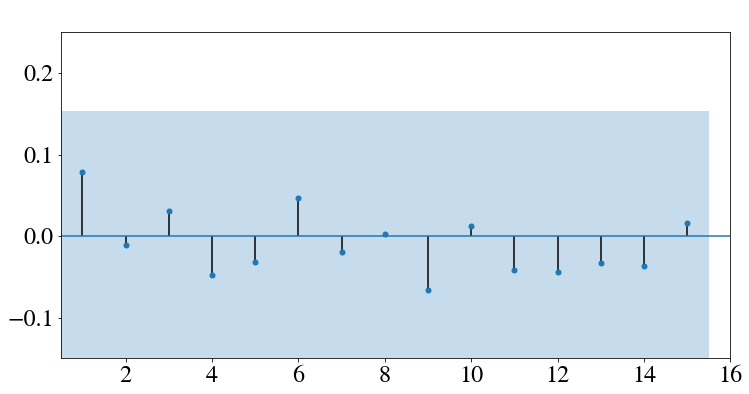

FINANCIAL ID THEFT: OVER $300 Q=4
################################################################
################################################################
FINANCIAL ID THEFT:$300 &UNDER
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[ 8.]
 [12.]
 [17.]
 [24.]]


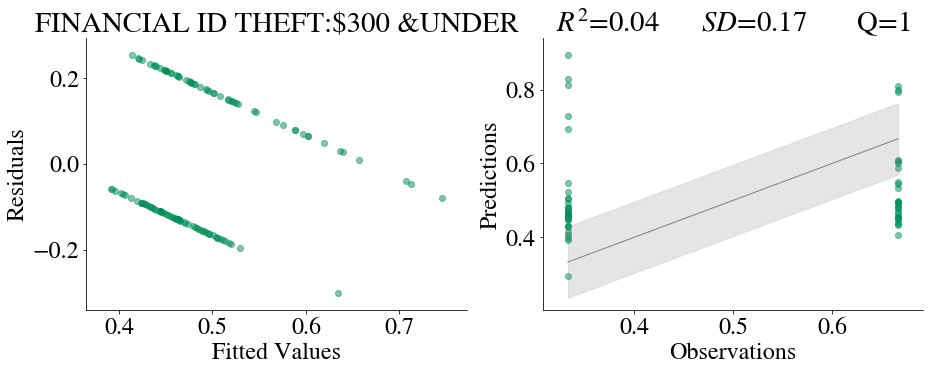

Ho null hypothesis
chi2 =1.7440389488166261
chi2Table =26.3
Equation coefficients
const                            0.279962
degree                          -0.344991
closeness_centrality            -0.021368
betweenness_centrality           0.159950
boardings                        0.544857
alightings                      -0.299333
L                                0.238966
C                                0.145872
$500 AND UNDER                   0.232384
ATTEMPT THEFT                   -0.031979
FINANCIAL ID THEFT: OVER $300    0.085799
FROM BUILDING                    0.064647
OVER $500                        0.077759
POCKET-PICKING                   0.171700
PURSE-SNATCHING                  0.030963
RETAIL THEFT                     0.398936
dtype: float64
                                     vif
degree                          2.856281
closeness_centrality            9.797813
betweenness_centrality          1.628474
boardings                       4.421181
alightings                

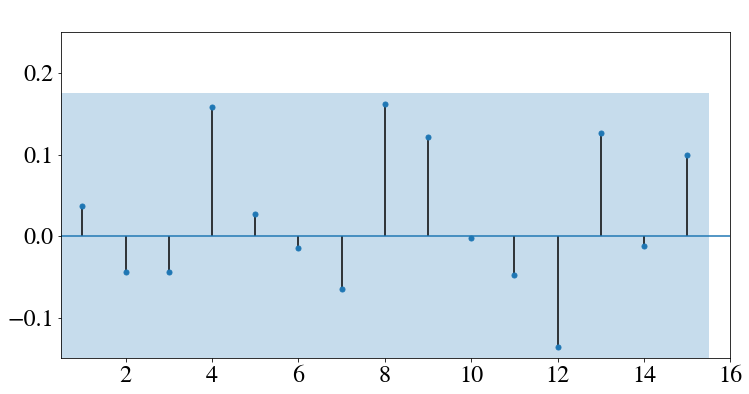

FINANCIAL ID THEFT:$300 &UNDER Q=1
################################################################


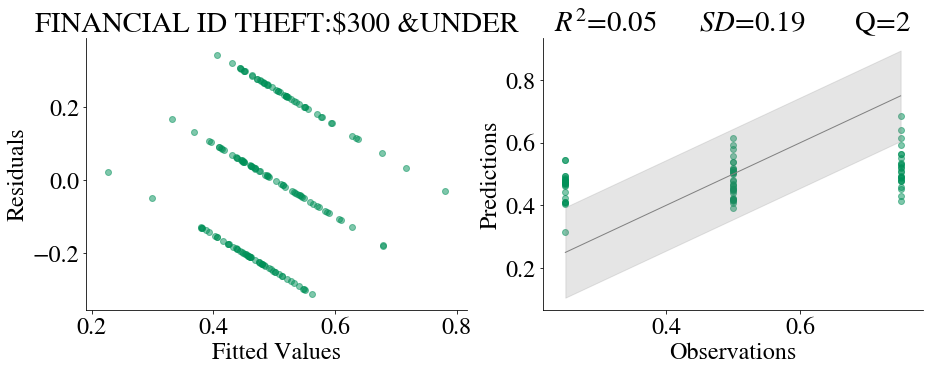

Ho null hypothesis
chi2 =0.6186660481429985
chi2Table =26.3
Equation coefficients
const                            0.279427
degree                           0.106593
closeness_centrality            -0.136971
betweenness_centrality          -0.043266
boardings                        0.332403
alightings                       0.002965
L                                0.290176
C                               -0.047315
$500 AND UNDER                   0.269995
ATTEMPT THEFT                   -0.308413
FINANCIAL ID THEFT: OVER $300    0.179265
FROM BUILDING                   -0.637207
OVER $500                        0.299101
POCKET-PICKING                   0.293954
PURSE-SNATCHING                  0.193068
RETAIL THEFT                     0.042636
dtype: float64
                                     vif
degree                          4.240274
closeness_centrality           14.879675
betweenness_centrality          3.303693
boardings                       3.022239
alightings                

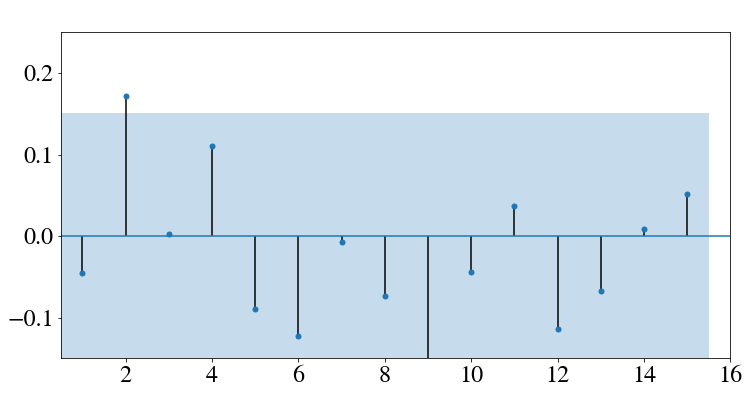

FINANCIAL ID THEFT:$300 &UNDER Q=2
################################################################


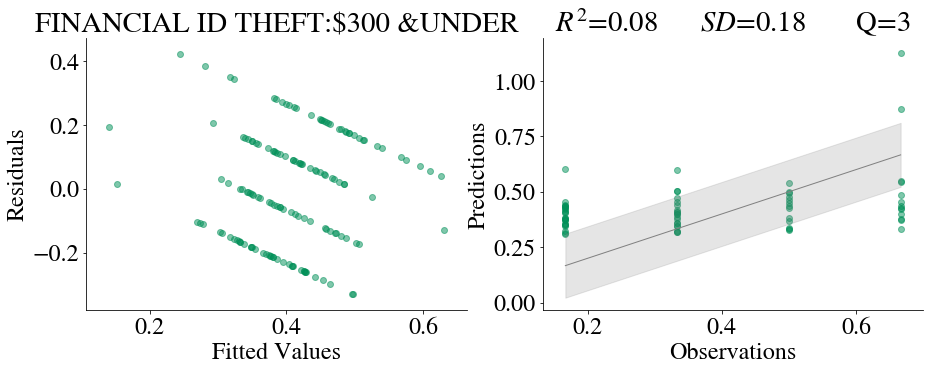

Ho null hypothesis
chi2 =2.3423472186042753
chi2Table =26.3
Equation coefficients
const                            0.103746
degree                           0.208616
closeness_centrality             0.036601
betweenness_centrality          -0.221551
boardings                        0.157992
alightings                      -0.010310
L                                0.497311
C                               -0.083755
$500 AND UNDER                   1.077229
ATTEMPT THEFT                   -0.485147
FINANCIAL ID THEFT: OVER $300    0.161044
FROM BUILDING                    0.797997
OVER $500                       -0.767836
POCKET-PICKING                  -0.127629
PURSE-SNATCHING                 -0.249075
RETAIL THEFT                     0.541035
dtype: float64
                                     vif
degree                          4.296344
closeness_centrality           13.969093
betweenness_centrality          3.830438
boardings                       2.937048
alightings                

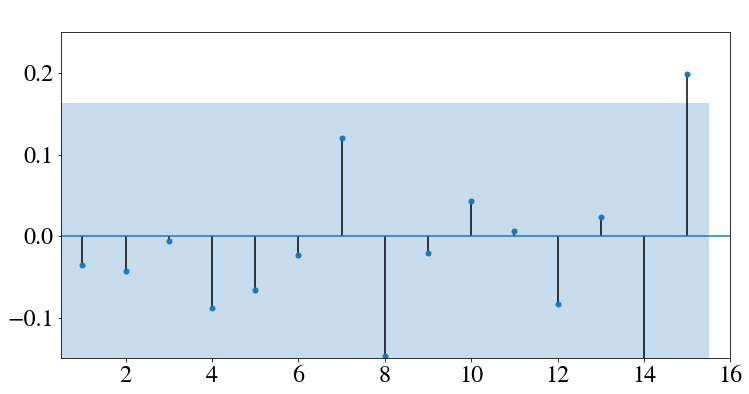

FINANCIAL ID THEFT:$300 &UNDER Q=3
################################################################


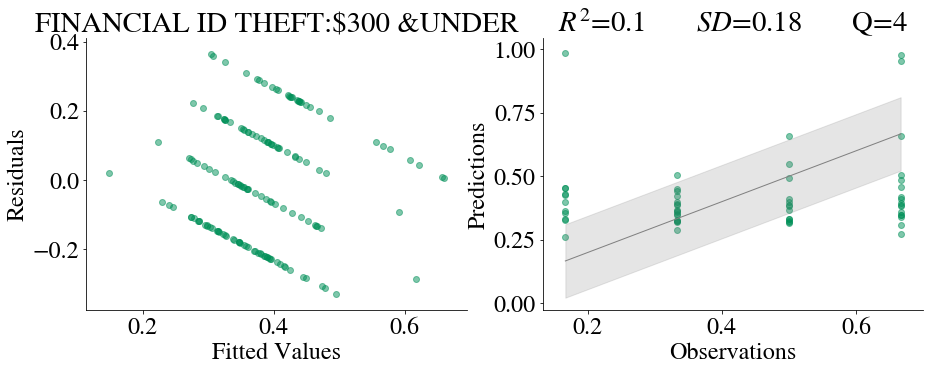

Ho null hypothesis
chi2 =3.1075684853227434
chi2Table =26.3
Equation coefficients
const                           -0.060337
degree                          -0.042222
closeness_centrality             0.058201
betweenness_centrality           0.449599
boardings                        0.198482
alightings                      -0.067506
L                                0.640275
C                               -0.054487
$500 AND UNDER                   0.800378
ATTEMPT THEFT                   -0.231282
FINANCIAL ID THEFT: OVER $300    0.220851
FROM BUILDING                    0.552815
OVER $500                       -0.278300
POCKET-PICKING                  -0.276115
PURSE-SNATCHING                 -0.113706
RETAIL THEFT                     0.425887
dtype: float64
                                     vif
degree                          5.346583
closeness_centrality           13.244636
betweenness_centrality          4.185446
boardings                       2.731711
alightings                

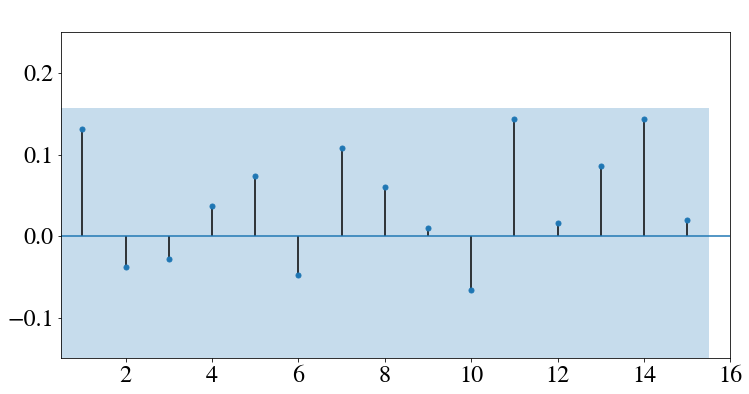

FINANCIAL ID THEFT:$300 &UNDER Q=4
################################################################
################################################################
FROM BUILDING
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[ 101.75]
 [ 177.  ]
 [ 259.  ]
 [1107.  ]]


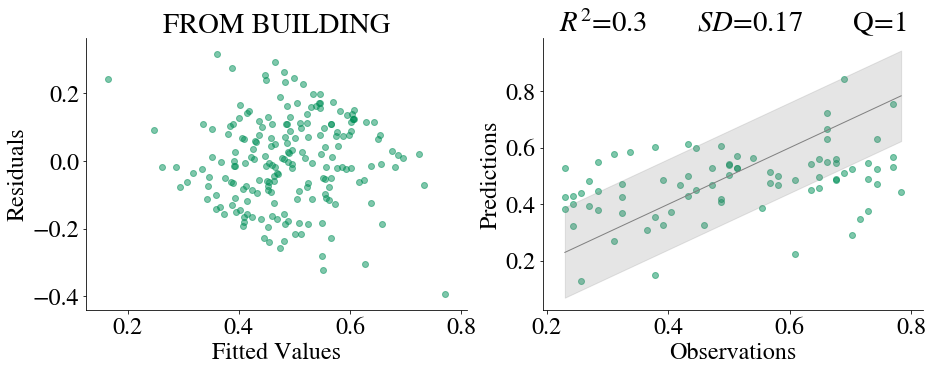

Ho null hypothesis
chi2 =2.3616446526606456
chi2Table =26.3
Equation coefficients
const                            -0.144195
degree                           -2.242847
closeness_centrality              0.110991
betweenness_centrality            0.662865
boardings                         0.085971
alightings                       -0.279087
L                                 0.816706
C                                 0.082217
$500 AND UNDER                    1.028208
ATTEMPT THEFT                    -0.106995
FINANCIAL ID THEFT: OVER $300     0.024700
FINANCIAL ID THEFT:$300 &UNDER    0.196556
OVER $500                        -0.012041
POCKET-PICKING                   -0.007081
PURSE-SNATCHING                  -0.261141
RETAIL THEFT                      0.159897
dtype: float64
                                      vif
degree                           4.954554
closeness_centrality            15.162505
betweenness_centrality           3.711165
boardings                        2.502059
aligh

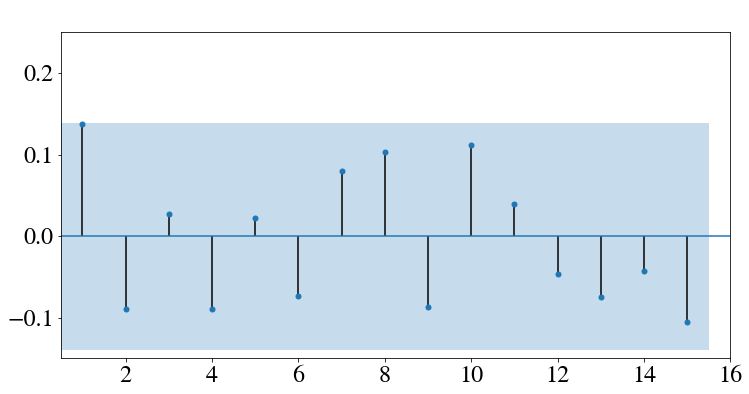

FROM BUILDING Q=1
################################################################


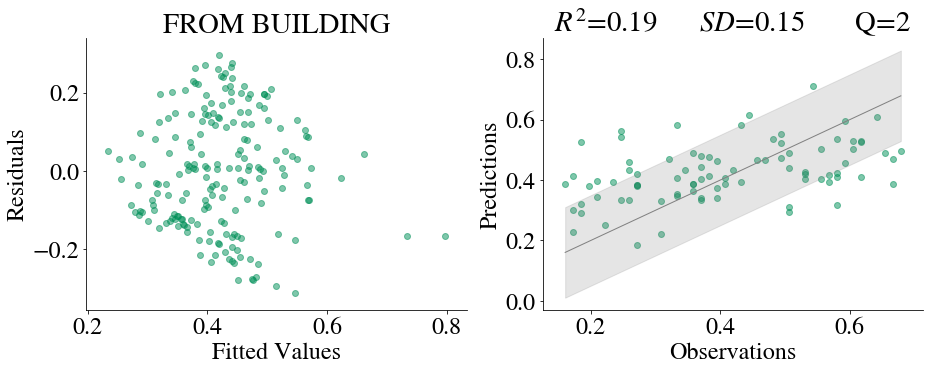

Ho null hypothesis
chi2 =1.7603266380427822
chi2Table =26.3
Equation coefficients
const                            -0.241859
degree                           -0.159758
closeness_centrality              0.057419
betweenness_centrality           -0.068986
boardings                         0.070007
alightings                       -0.021845
L                                 1.013573
C                                -0.023764
$500 AND UNDER                    0.801214
ATTEMPT THEFT                     0.066598
FINANCIAL ID THEFT: OVER $300     0.309023
FINANCIAL ID THEFT:$300 &UNDER   -0.161461
OVER $500                        -0.006367
POCKET-PICKING                    0.343271
PURSE-SNATCHING                  -0.365501
RETAIL THEFT                      0.203489
dtype: float64
                                      vif
degree                           2.770345
closeness_centrality            12.289671
betweenness_centrality           2.468723
boardings                        3.306571
aligh

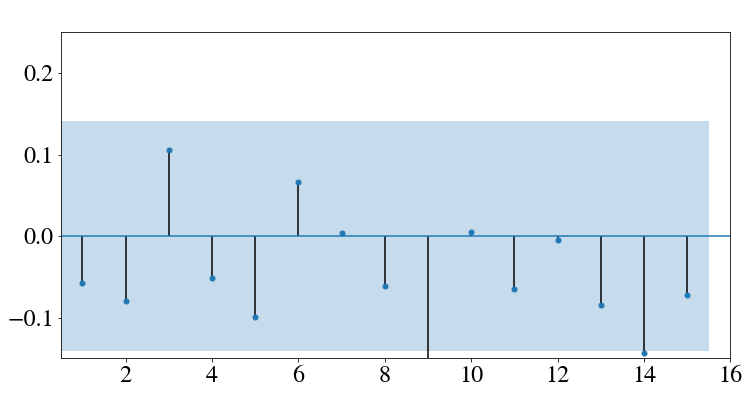

FROM BUILDING Q=2
################################################################


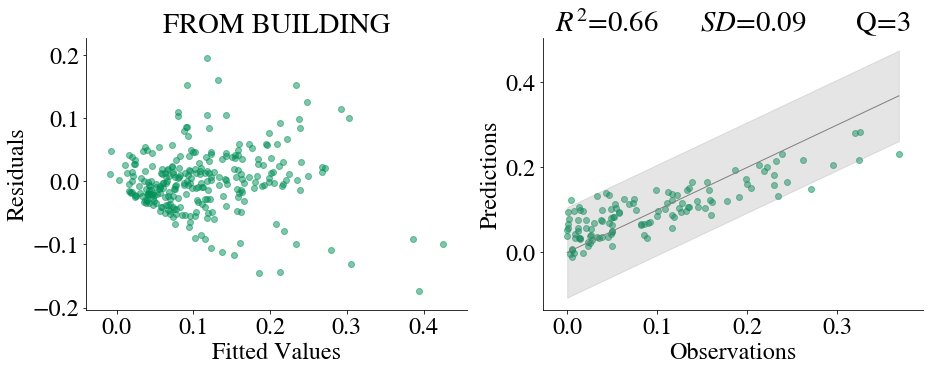

Ho null hypothesis
chi2 =4.4117572888717245
chi2Table =26.3
Equation coefficients
const                            -0.266994
degree                           -0.020105
closeness_centrality              0.020858
betweenness_centrality            0.002566
boardings                         0.035166
alightings                        0.000242
L                                 0.912989
C                                 0.014662
$500 AND UNDER                    0.187385
ATTEMPT THEFT                     0.102019
FINANCIAL ID THEFT: OVER $300     0.075603
FINANCIAL ID THEFT:$300 &UNDER    0.053200
OVER $500                         0.275792
POCKET-PICKING                    0.134152
PURSE-SNATCHING                   0.055624
RETAIL THEFT                      0.118013
dtype: float64
                                      vif
degree                           4.441149
closeness_centrality            16.701776
betweenness_centrality           3.660539
boardings                        2.947310
aligh

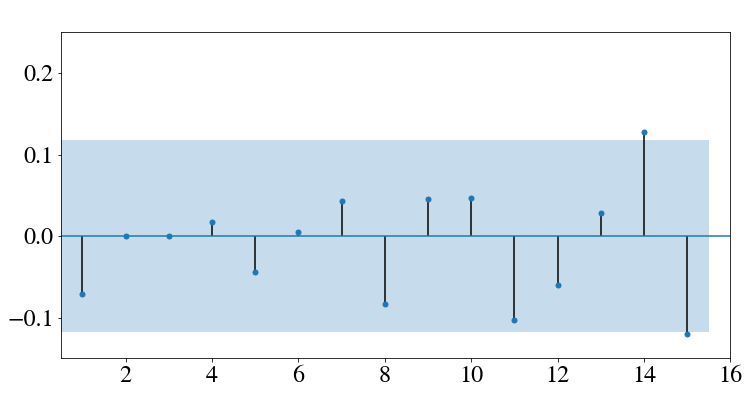

FROM BUILDING Q=3
################################################################


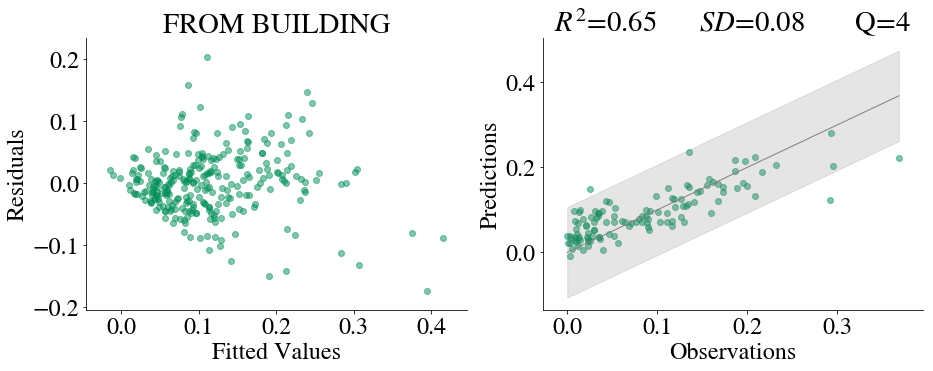

Ho null hypothesis
chi2 =4.167363686514785
chi2Table =26.3
Equation coefficients
const                            -0.263489
degree                           -0.009320
closeness_centrality              0.012839
betweenness_centrality            0.042853
boardings                         0.022931
alightings                        0.005109
L                                 0.850859
C                                 0.047711
$500 AND UNDER                    0.151684
ATTEMPT THEFT                     0.098213
FINANCIAL ID THEFT: OVER $300     0.058641
FINANCIAL ID THEFT:$300 &UNDER    0.104166
OVER $500                         0.284463
POCKET-PICKING                    0.119062
PURSE-SNATCHING                   0.071565
RETAIL THEFT                      0.124901
dtype: float64
                                      vif
degree                           3.597827
closeness_centrality            16.312580
betweenness_centrality           2.876575
boardings                        3.032339
alight

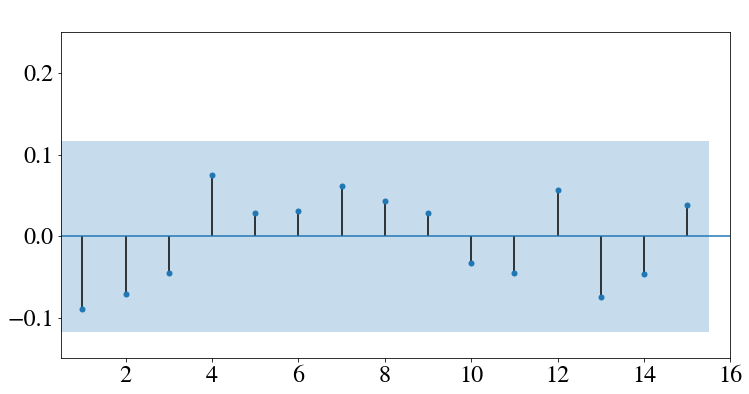

FROM BUILDING Q=4
################################################################
################################################################
OVER $500
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[189.5]
 [271. ]
 [359. ]
 [846. ]]


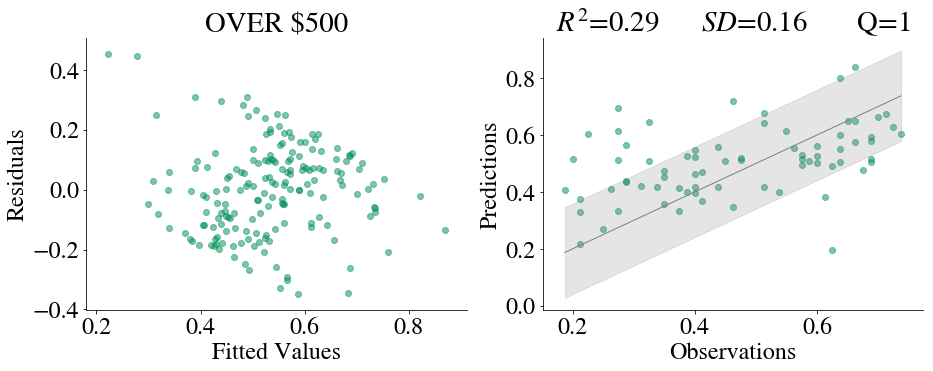

Ho null hypothesis
chi2 =2.1477315181874403
chi2Table =26.3
Equation coefficients
const                            -0.773535
degree                           -0.147598
closeness_centrality              0.039916
betweenness_centrality            0.224025
boardings                        -0.120719
alightings                       -0.202817
L                                 1.917320
C                                -0.112331
$500 AND UNDER                    0.992050
ATTEMPT THEFT                     0.269550
FINANCIAL ID THEFT: OVER $300     0.108433
FINANCIAL ID THEFT:$300 &UNDER    0.091766
FROM BUILDING                     0.598954
POCKET-PICKING                   -0.099242
PURSE-SNATCHING                   0.254010
RETAIL THEFT                      0.477362
dtype: float64
                                      vif
degree                           2.620478
closeness_centrality            12.120473
betweenness_centrality           2.071668
boardings                        1.887067
aligh

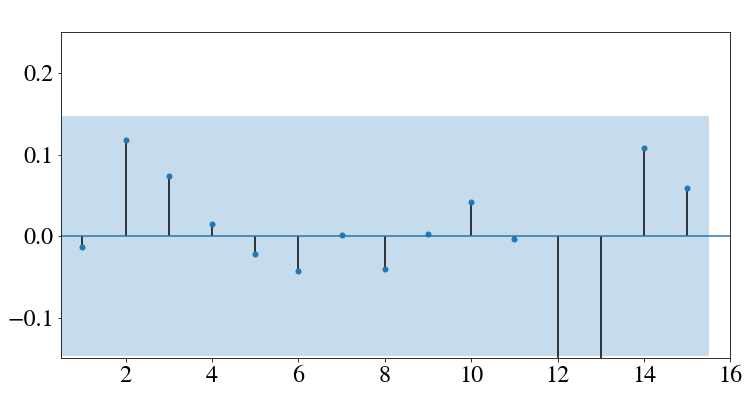

OVER $500 Q=1
################################################################


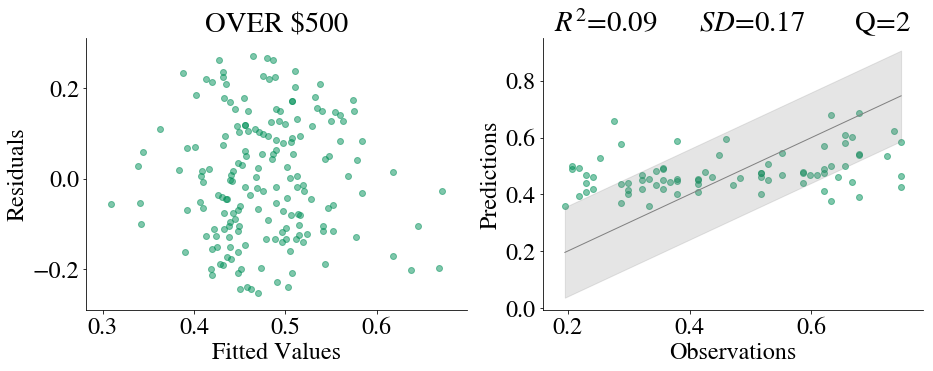

Ho null hypothesis
chi2 =0.8294022627135105
chi2Table =26.3
Equation coefficients
const                            -0.019542
degree                           -0.003032
closeness_centrality              0.002554
betweenness_centrality           -0.157990
boardings                         0.104086
alightings                        0.110922
L                                 0.646219
C                                 0.118409
$500 AND UNDER                    0.514360
ATTEMPT THEFT                     0.163121
FINANCIAL ID THEFT: OVER $300     0.115031
FINANCIAL ID THEFT:$300 &UNDER   -0.049254
FROM BUILDING                     0.236847
POCKET-PICKING                   -0.093556
PURSE-SNATCHING                  -0.153971
RETAIL THEFT                      0.158871
dtype: float64
                                      vif
degree                           4.207150
closeness_centrality            15.160916
betweenness_centrality           3.888741
boardings                        3.184878
aligh

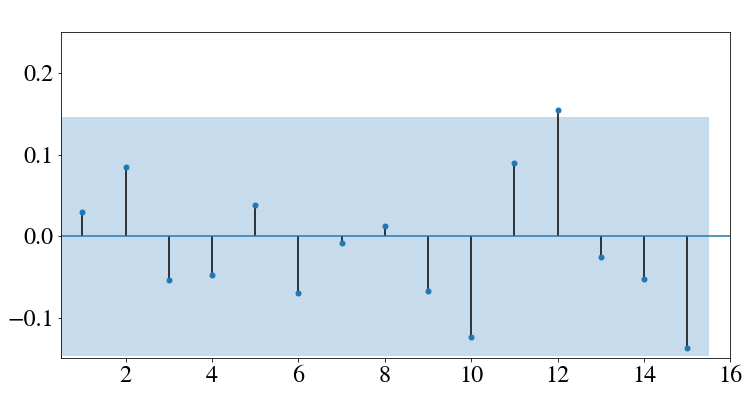

OVER $500 Q=2
################################################################


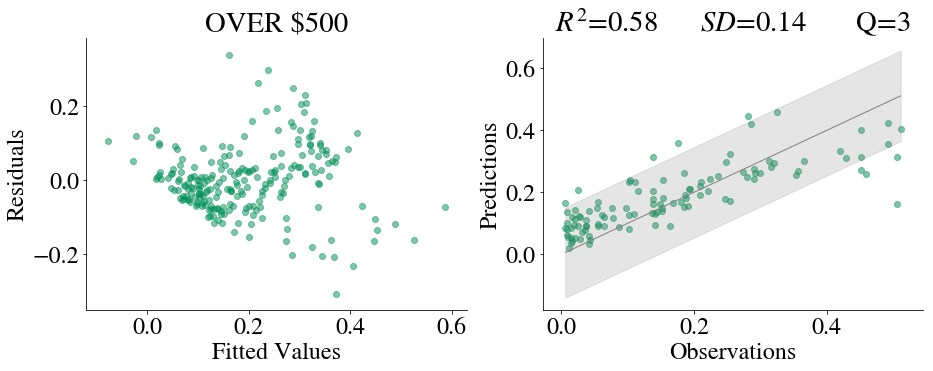

Ho null hypothesis
chi2 =5.961526199139257
chi2Table =26.3
Equation coefficients
const                            -0.500630
degree                           -0.003553
closeness_centrality             -0.009576
betweenness_centrality           -0.075086
boardings                        -0.038659
alightings                       -0.020483
L                                 0.949421
C                                 0.025561
$500 AND UNDER                    0.760303
ATTEMPT THEFT                     0.373341
FINANCIAL ID THEFT: OVER $300    -0.011847
FINANCIAL ID THEFT:$300 &UNDER   -0.002227
FROM BUILDING                     0.642359
POCKET-PICKING                    0.170426
PURSE-SNATCHING                   0.001310
RETAIL THEFT                      0.005923
dtype: float64
                                      vif
degree                           2.412400
closeness_centrality            11.989581
betweenness_centrality           1.751556
boardings                        2.497225
alight

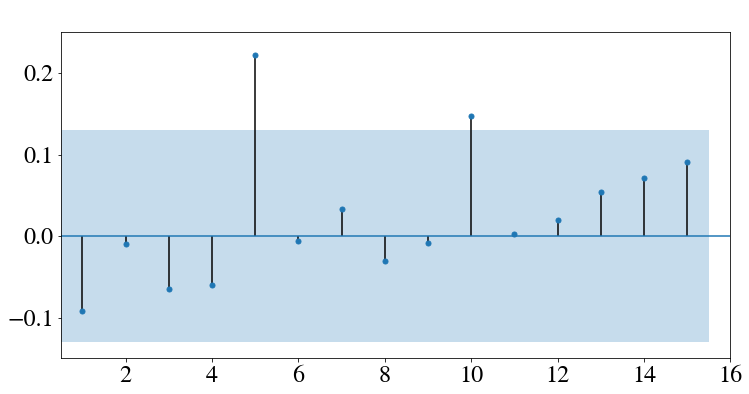

OVER $500 Q=3
################################################################


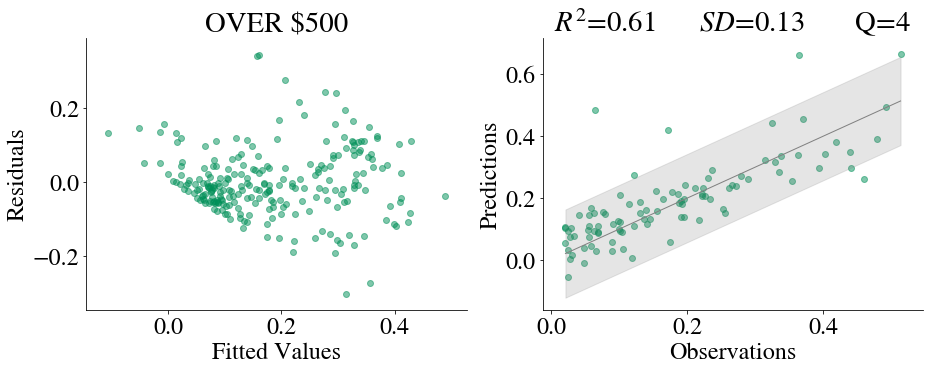

Ho null hypothesis
chi2 =9.020791873145955
chi2Table =26.3
Equation coefficients
const                            -0.553828
degree                           -0.024050
closeness_centrality             -0.017906
betweenness_centrality           -0.038711
boardings                        -0.057611
alightings                       -0.012009
L                                 1.140468
C                                -0.100357
$500 AND UNDER                    0.743794
ATTEMPT THEFT                     0.337527
FINANCIAL ID THEFT: OVER $300     0.023503
FINANCIAL ID THEFT:$300 &UNDER   -0.072505
FROM BUILDING                     0.720377
POCKET-PICKING                    0.270439
PURSE-SNATCHING                   0.059409
RETAIL THEFT                      0.054643
dtype: float64
                                      vif
degree                           3.140381
closeness_centrality            11.546331
betweenness_centrality           2.349327
boardings                        3.537487
alight

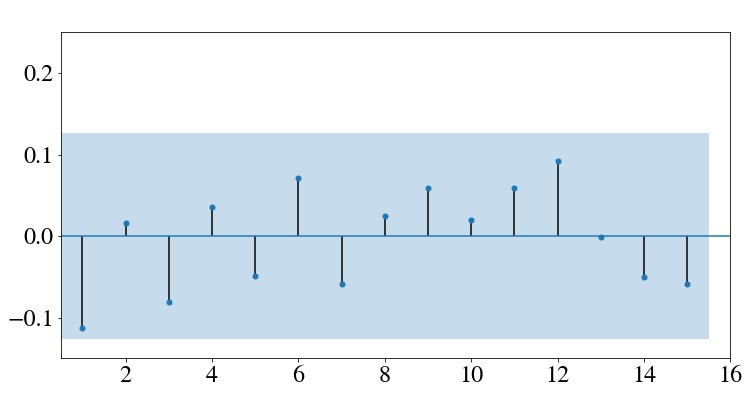

OVER $500 Q=4
################################################################
################################################################
POCKET-PICKING
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[  7.]
 [ 14.]
 [ 33.]
 [388.]]


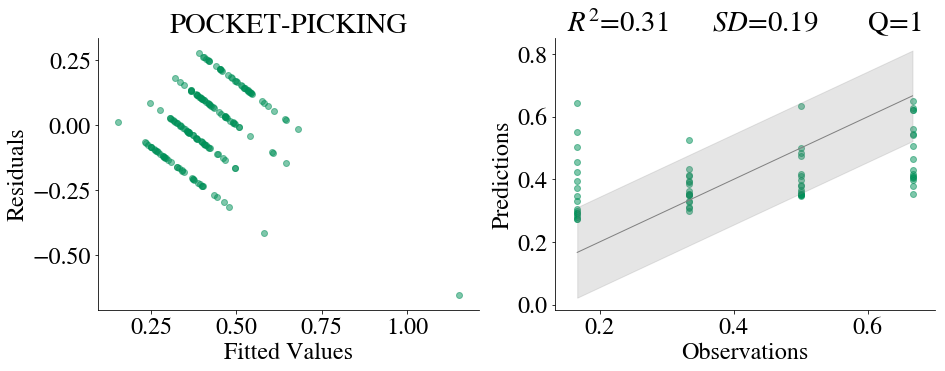

Ho null hypothesis
chi2 =1.6181987900735582
chi2Table =26.3
Equation coefficients
const                            -0.317455
degree                            0.000007
closeness_centrality              0.082374
betweenness_centrality           -0.212034
boardings                         0.126373
alightings                        0.026795
L                                 1.363123
C                                 0.404355
$500 AND UNDER                    0.790056
ATTEMPT THEFT                     0.005460
FINANCIAL ID THEFT: OVER $300     0.096664
FINANCIAL ID THEFT:$300 &UNDER   -0.029511
FROM BUILDING                     0.170443
OVER $500                         0.032998
PURSE-SNATCHING                  -0.048770
RETAIL THEFT                      0.211567
dtype: float64
                                      vif
degree                           7.894561
closeness_centrality            13.970808
betweenness_centrality           8.628974
boardings                        2.214765
aligh

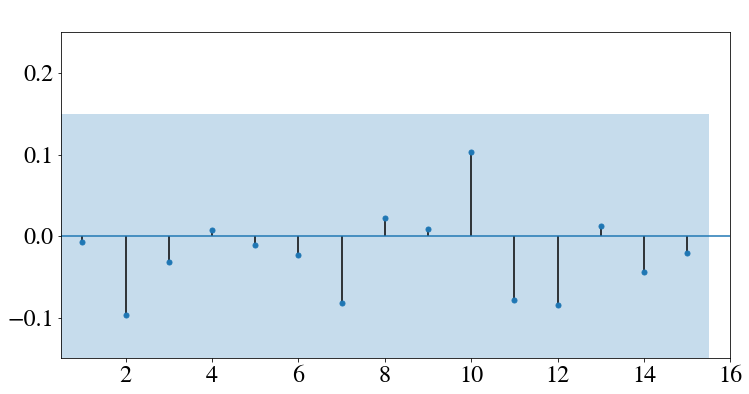

POCKET-PICKING Q=1
################################################################


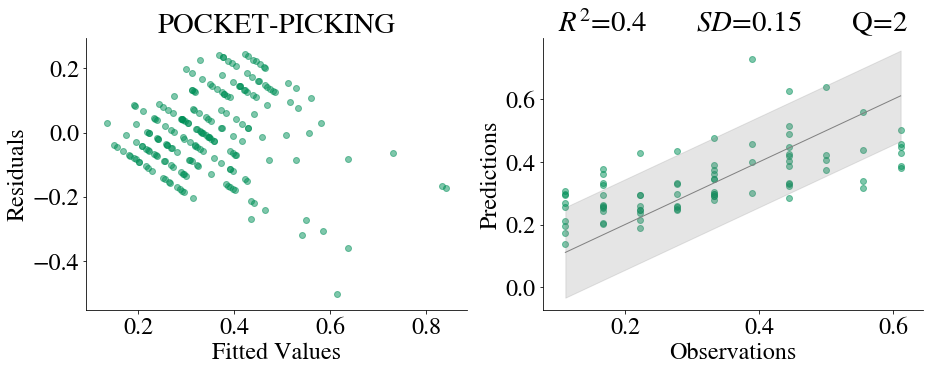

Ho null hypothesis
chi2 =2.7147379946582033
chi2Table =26.3
Equation coefficients
const                            -0.402142
degree                           -0.120370
closeness_centrality              0.100110
betweenness_centrality           -0.027162
boardings                         0.140486
alightings                        0.021116
L                                 1.396060
C                                 0.536523
$500 AND UNDER                    0.302187
ATTEMPT THEFT                     0.281309
FINANCIAL ID THEFT: OVER $300     0.159680
FINANCIAL ID THEFT:$300 &UNDER   -0.147206
FROM BUILDING                     0.277660
OVER $500                         0.251399
PURSE-SNATCHING                   0.088715
RETAIL THEFT                      0.300445
dtype: float64
                                      vif
degree                           2.390701
closeness_centrality            13.921610
betweenness_centrality           1.788418
boardings                        3.113025
aligh

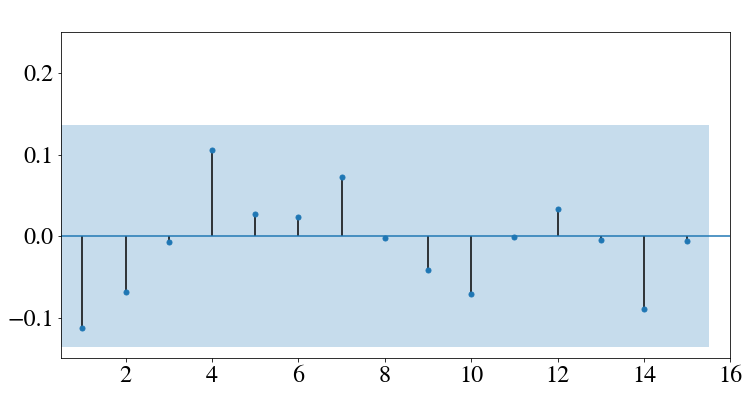

POCKET-PICKING Q=2
################################################################


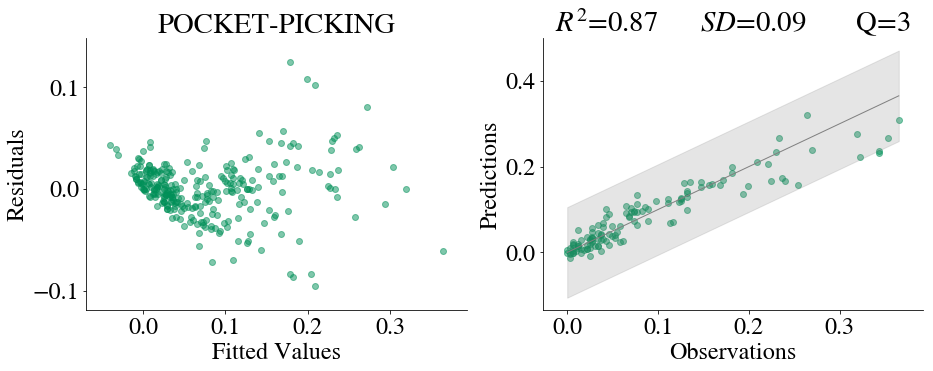

Ho null hypothesis
chi2 =8.654403878367477
chi2Table =26.3
Equation coefficients
const                            -0.156746
degree                           -0.037006
closeness_centrality              0.021271
betweenness_centrality           -0.029923
boardings                         0.023397
alightings                        0.051299
L                                 0.728362
C                                 0.152889
$500 AND UNDER                    0.076374
ATTEMPT THEFT                     0.106655
FINANCIAL ID THEFT: OVER $300    -0.010524
FINANCIAL ID THEFT:$300 &UNDER   -0.022913
FROM BUILDING                     0.257189
OVER $500                         0.133776
PURSE-SNATCHING                   0.067849
RETAIL THEFT                      0.116698
dtype: float64
                                      vif
degree                           4.824130
closeness_centrality             8.370428
betweenness_centrality           4.280960
boardings                        3.779932
alight

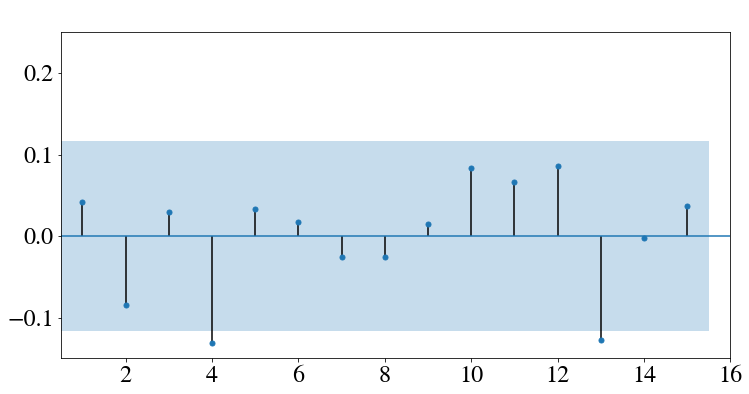

POCKET-PICKING Q=3
################################################################


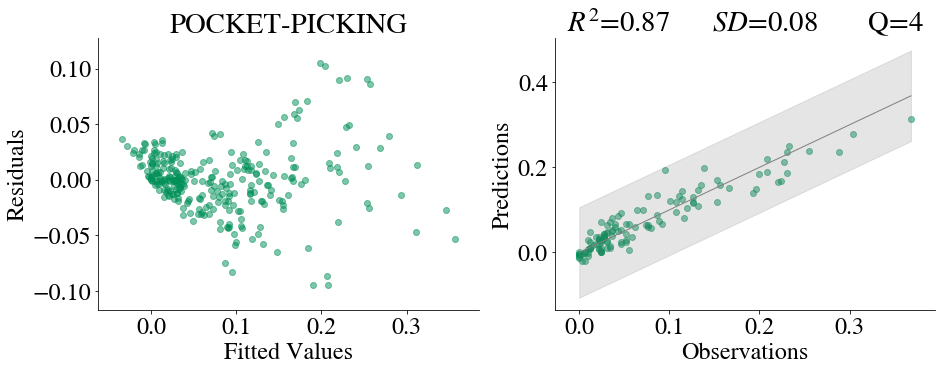

Ho null hypothesis
chi2 =8.755008096916152
chi2Table =26.3
Equation coefficients
const                            -0.154884
degree                           -0.013042
closeness_centrality              0.005643
betweenness_centrality            0.010988
boardings                         0.039850
alightings                        0.029271
L                                 0.745743
C                                 0.088600
$500 AND UNDER                    0.090992
ATTEMPT THEFT                     0.100293
FINANCIAL ID THEFT: OVER $300    -0.030178
FINANCIAL ID THEFT:$300 &UNDER   -0.015077
FROM BUILDING                     0.254188
OVER $500                         0.134803
PURSE-SNATCHING                   0.079790
RETAIL THEFT                      0.135166
dtype: float64
                                      vif
degree                           5.844438
closeness_centrality             7.514561
betweenness_centrality           5.401757
boardings                        3.292303
alight

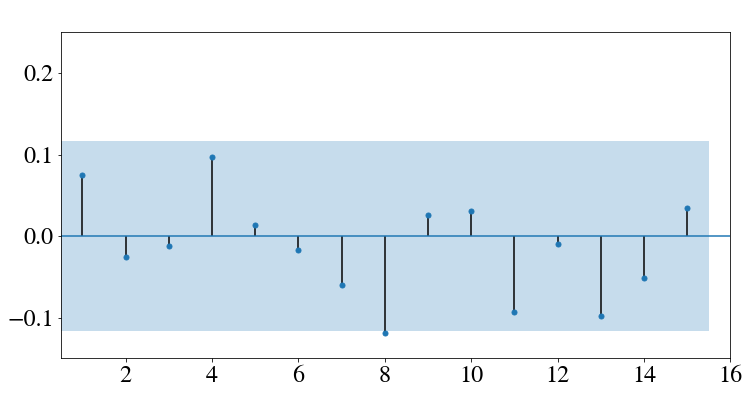

POCKET-PICKING Q=4
################################################################
################################################################
PURSE-SNATCHING
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[ 8.]
 [15.]
 [25.]
 [54.]]


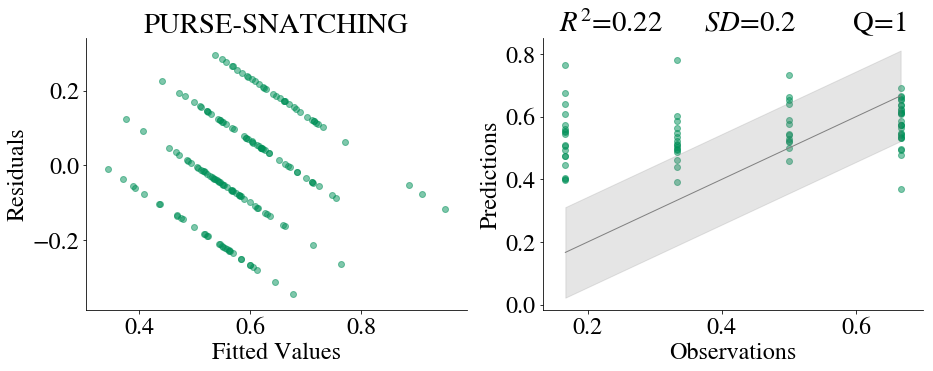

Ho null hypothesis
chi2 =0.9418422222204538
chi2Table =26.3
Equation coefficients
const                             0.207079
degree                           -0.239279
closeness_centrality             -0.120891
betweenness_centrality            0.154332
boardings                         0.420068
alightings                        0.011835
L                                 0.955025
C                                 0.127621
$500 AND UNDER                    0.509852
ATTEMPT THEFT                     0.215408
FINANCIAL ID THEFT: OVER $300     0.123418
FINANCIAL ID THEFT:$300 &UNDER   -0.020896
FROM BUILDING                     0.197287
OVER $500                        -0.458473
POCKET-PICKING                    0.175697
RETAIL THEFT                     -0.051169
dtype: float64
                                      vif
degree                           2.616253
closeness_centrality            14.461483
betweenness_centrality           1.554248
boardings                        3.016754
aligh

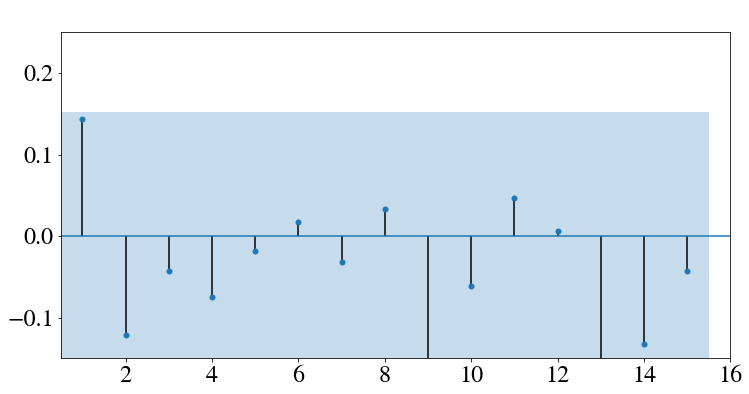

PURSE-SNATCHING Q=1
################################################################


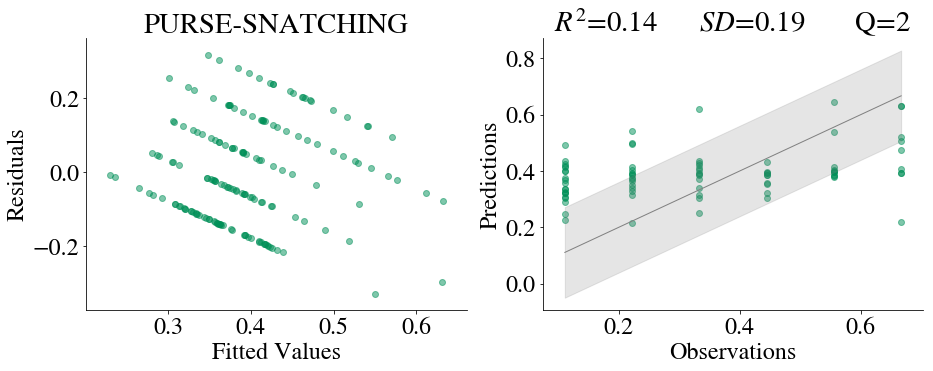

Ho null hypothesis
chi2 =1.4798541148179385
chi2Table =26.3
Equation coefficients
const                             0.060735
degree                           -0.084454
closeness_centrality              0.114839
betweenness_centrality            0.064644
boardings                         0.215109
alightings                       -0.149500
L                                 0.699832
C                                -0.303366
$500 AND UNDER                    0.473530
ATTEMPT THEFT                    -0.406364
FINANCIAL ID THEFT: OVER $300     0.134555
FINANCIAL ID THEFT:$300 &UNDER   -0.230443
FROM BUILDING                     0.204140
OVER $500                        -0.082849
POCKET-PICKING                    0.125278
RETAIL THEFT                      0.440028
dtype: float64
                                      vif
degree                           4.346160
closeness_centrality            13.654220
betweenness_centrality           3.664479
boardings                        3.456282
aligh

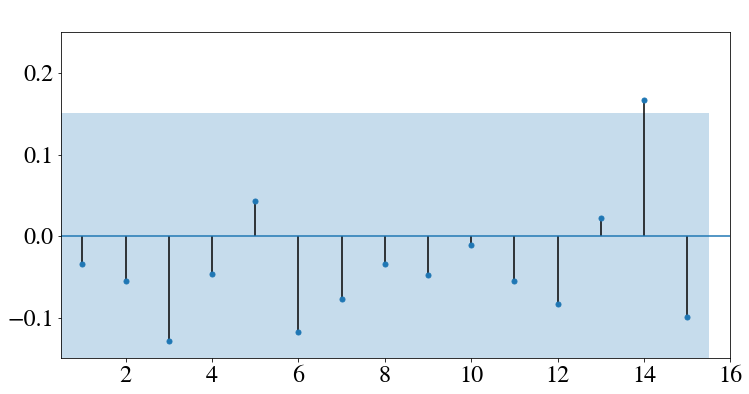

PURSE-SNATCHING Q=2
################################################################


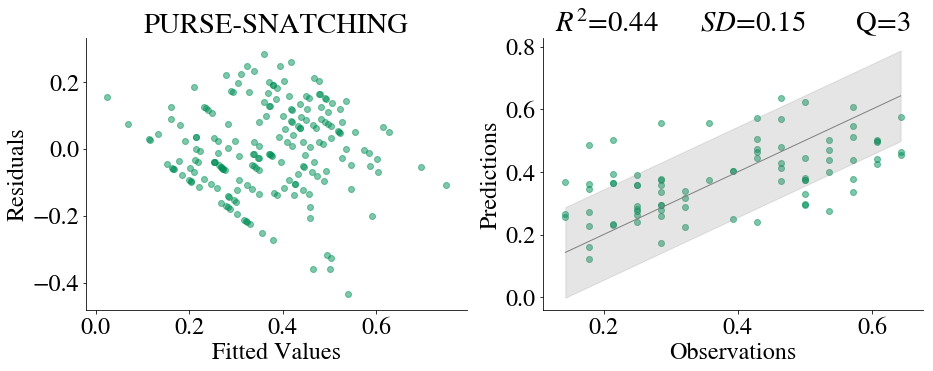

Ho null hypothesis
chi2 =2.7295409154193266
chi2Table =26.3
Equation coefficients
const                            -0.357229
degree                            0.214957
closeness_centrality             -0.064999
betweenness_centrality           -0.065526
boardings                         0.318916
alightings                        0.118829
L                                 0.922627
C                                 0.197934
$500 AND UNDER                    1.451101
ATTEMPT THEFT                    -0.146119
FINANCIAL ID THEFT: OVER $300     0.159218
FINANCIAL ID THEFT:$300 &UNDER    0.057254
FROM BUILDING                    -0.201153
OVER $500                        -0.598984
POCKET-PICKING                    0.326828
RETAIL THEFT                      0.291457
dtype: float64
                                      vif
degree                           5.059128
closeness_centrality            10.125954
betweenness_centrality           3.756171
boardings                        2.649973
aligh

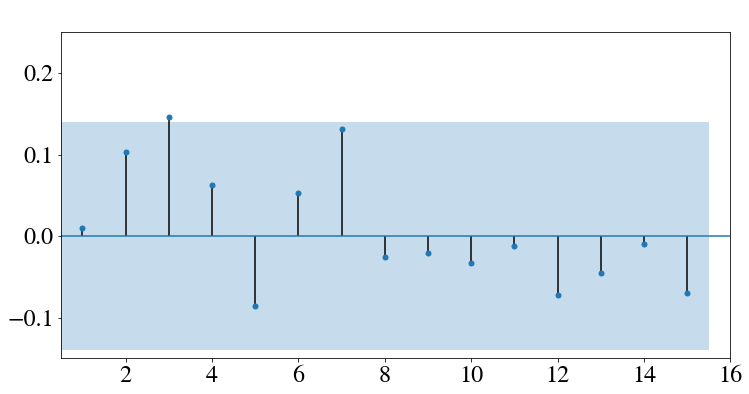

PURSE-SNATCHING Q=3
################################################################


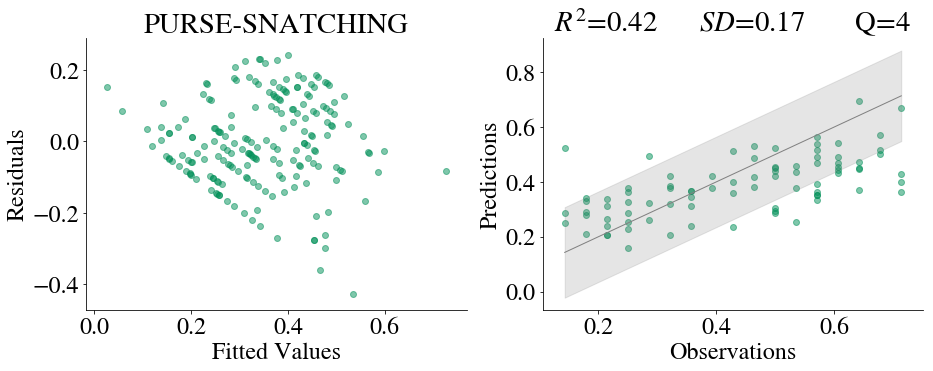

Ho null hypothesis
chi2 =2.5424541521083617
chi2Table =26.3
Equation coefficients
const                            -0.336968
degree                            0.155064
closeness_centrality             -0.070275
betweenness_centrality           -0.041428
boardings                         0.105772
alightings                        0.185650
L                                 0.935673
C                                 0.042987
$500 AND UNDER                    1.413728
ATTEMPT THEFT                    -0.119691
FINANCIAL ID THEFT: OVER $300     0.121567
FINANCIAL ID THEFT:$300 &UNDER    0.041427
FROM BUILDING                    -0.056184
OVER $500                        -0.606509
POCKET-PICKING                    0.265618
RETAIL THEFT                      0.412663
dtype: float64
                                      vif
degree                           4.413872
closeness_centrality            10.136208
betweenness_centrality           3.307834
boardings                        2.528151
aligh

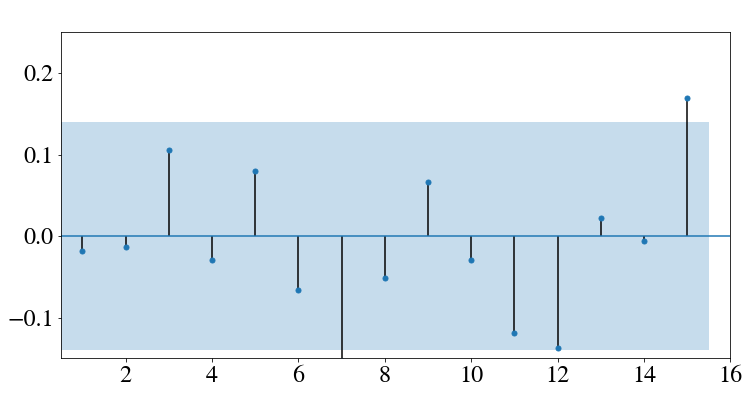

PURSE-SNATCHING Q=4
################################################################
################################################################
RETAIL THEFT
['$500 AND UNDER', 'ATTEMPT THEFT', 'FINANCIAL ID THEFT: OVER $300', 'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500', 'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'] [[  17.25]
 [  60.  ]
 [ 222.  ]
 [1573.  ]]


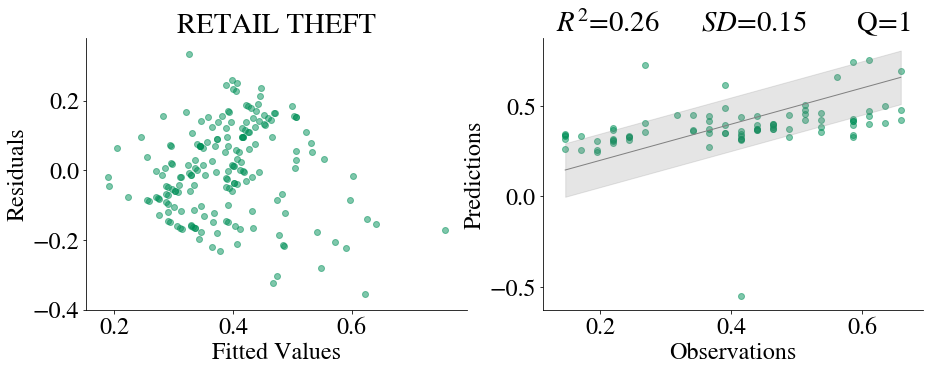

Ho null hypothesis
chi2 =4.54074535127015
chi2Table =26.3
Equation coefficients
const                            -0.039627
degree                           -0.832527
closeness_centrality              0.075681
betweenness_centrality           -0.159532
boardings                        -0.024859
alightings                        0.047127
L                                 1.073177
C                                -0.301681
$500 AND UNDER                    0.525187
ATTEMPT THEFT                     0.001291
FINANCIAL ID THEFT: OVER $300    -0.049759
FINANCIAL ID THEFT:$300 &UNDER    0.068354
FROM BUILDING                     0.485411
OVER $500                        -0.181011
POCKET-PICKING                    0.142289
PURSE-SNATCHING                   0.017695
dtype: float64
                                      vif
degree                           3.837612
closeness_centrality            13.792016
betweenness_centrality           2.612091
boardings                        2.162461
alighti

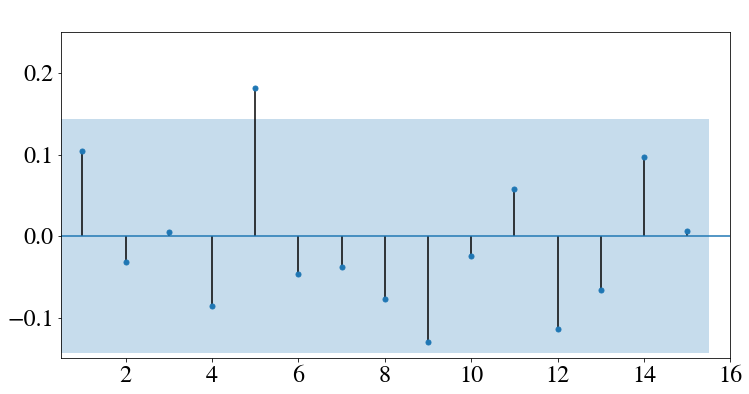

RETAIL THEFT Q=1
################################################################


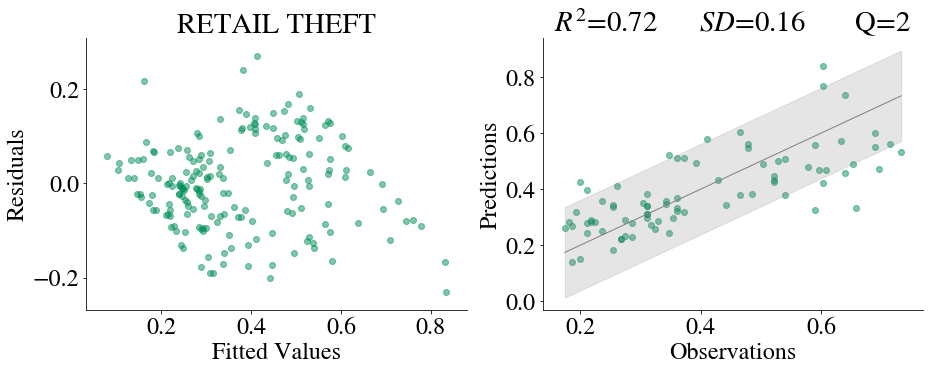

Ho null hypothesis
chi2 =3.7823764299645486
chi2Table =26.3
Equation coefficients
const                            -0.291773
degree                           -0.276015
closeness_centrality              0.034748
betweenness_centrality            0.333087
boardings                         0.064898
alightings                        0.069854
L                                 1.764228
C                                -0.214318
$500 AND UNDER                    0.735495
ATTEMPT THEFT                     0.415380
FINANCIAL ID THEFT: OVER $300     0.166727
FINANCIAL ID THEFT:$300 &UNDER   -0.122981
FROM BUILDING                    -0.640014
OVER $500                         0.369849
POCKET-PICKING                   -0.129289
PURSE-SNATCHING                  -0.019352
dtype: float64
                                      vif
degree                           4.771622
closeness_centrality            10.187549
betweenness_centrality           4.474850
boardings                        2.521830
aligh

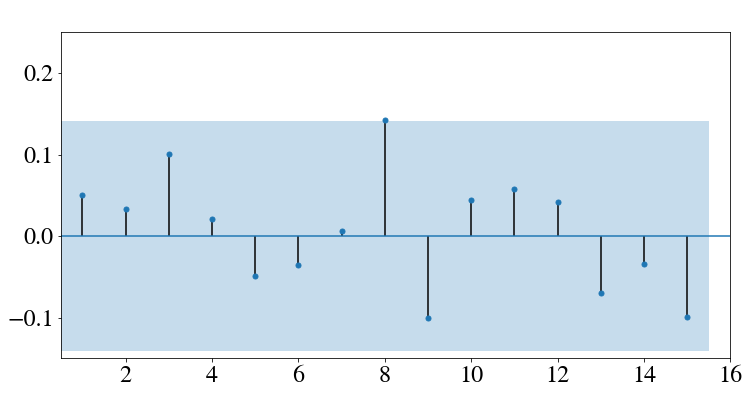

RETAIL THEFT Q=2
################################################################


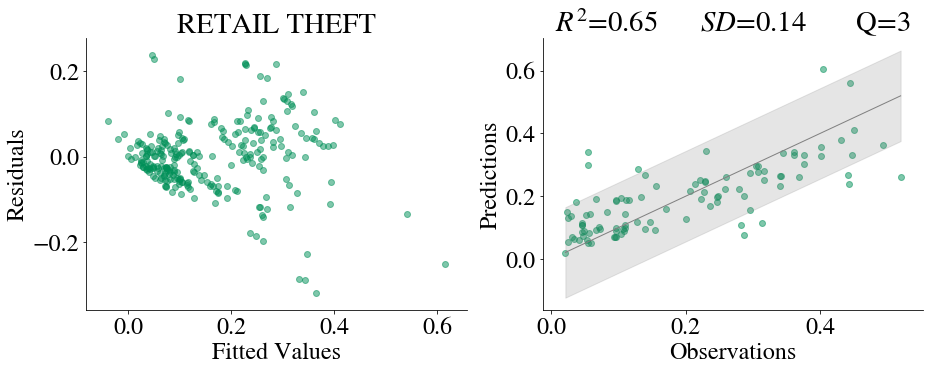

Ho null hypothesis
chi2 =6.144716299363684
chi2Table =26.3
Equation coefficients
const                            -0.264511
degree                           -0.069305
closeness_centrality              0.017970
betweenness_centrality           -0.004817
boardings                         0.038609
alightings                        0.040651
L                                 1.124380
C                                 0.066669
$500 AND UNDER                    1.068603
ATTEMPT THEFT                     0.155830
FINANCIAL ID THEFT: OVER $300    -0.124918
FINANCIAL ID THEFT:$300 &UNDER    0.273474
FROM BUILDING                     0.088793
OVER $500                        -0.316012
POCKET-PICKING                   -0.288426
PURSE-SNATCHING                  -0.123174
dtype: float64
                                      vif
degree                           5.592895
closeness_centrality            11.849813
betweenness_centrality           4.448053
boardings                        3.658739
alight

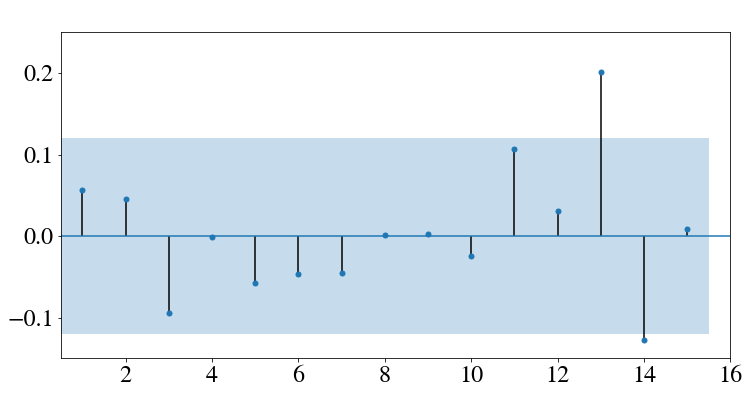

RETAIL THEFT Q=3
################################################################


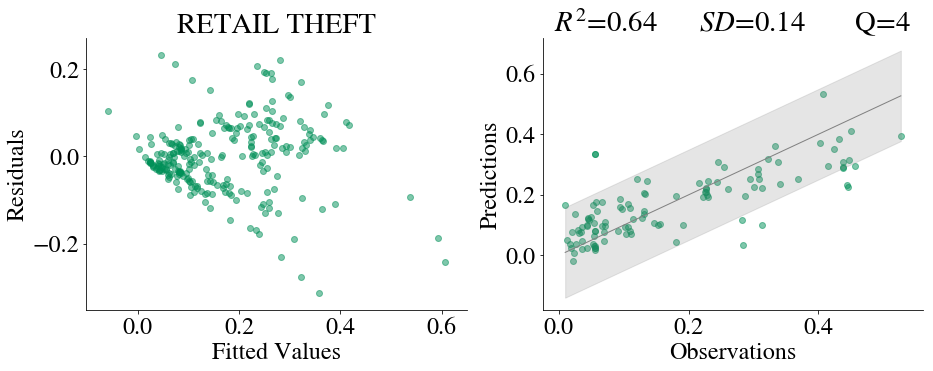

Ho null hypothesis
chi2 =7.707111483563464
chi2Table =26.3
Equation coefficients
const                            -0.273800
degree                           -0.135718
closeness_centrality              0.055095
betweenness_centrality            0.035815
boardings                         0.008006
alightings                        0.036511
L                                 1.094832
C                                 0.050206
$500 AND UNDER                    1.045495
ATTEMPT THEFT                     0.126324
FINANCIAL ID THEFT: OVER $300    -0.030057
FINANCIAL ID THEFT:$300 &UNDER    0.247061
FROM BUILDING                     0.009410
OVER $500                        -0.290317
POCKET-PICKING                   -0.241845
PURSE-SNATCHING                  -0.136817
dtype: float64
                                      vif
degree                           5.642052
closeness_centrality            10.681050
betweenness_centrality           4.872738
boardings                        3.980318
alight

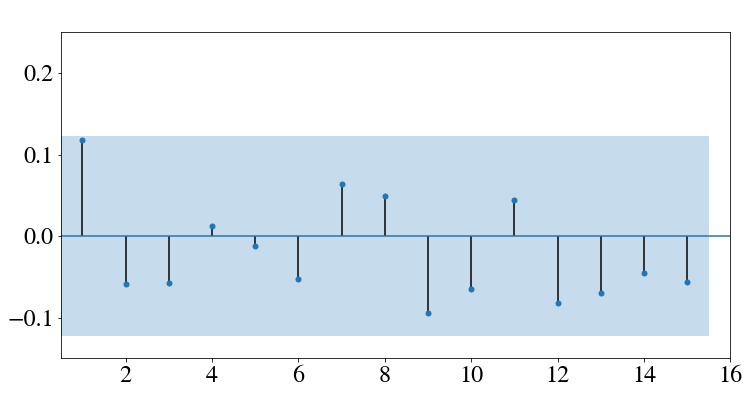

RETAIL THEFT Q=4
################################################################


In [18]:
## Iterate over each theft type and quartile
ths = [
        '$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
       'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
       'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'
    ]

rs = []
ecm = []
corrP = []
corrPV = []

for th in ths:
    print('################################################################') 
    print(th)

    df2 = prepare_df2(th, dbTH, df1)
    df2 = df2[df2[th] > 0]
    ix = outliers_thefts(df2, th)
    df2 = df2[ix]
    
    qs = df2[[th]].quantile([.25, .5, .75, 1]).values
    print(ths, qs)
    rsQ = []
    ecmQ = []
    corrPQ = []
    corrPVQ = []
    
    for q in range(4):
        if q < 3:
            df3 = df2[(df2[[th]] >= qs[q]).values & (df2[[th]] < qs[q+1]).values ]
        else:
            df3 = df2[(df2[[th]] >= qs[q-1]).values & (df2[[th]] < qs[q]).values ]
            
        ths1 = [m for m in ths if m != th]
        d = np.sum(df3[th].values)/np.sum(df3[ths1].sum(axis=0).values)
        di = df3[th]/df3[ths1].sum(axis=1)
        L = di/d
        C = df3[th]/df3[['boardings', 'alightings']].sum(axis=1)
        dft = pd.concat([ df3[[
                            'degree', 
                            'closeness_centrality',
                            'betweenness_centrality', 
                            'boardings', 'alightings']],
                            L,
                            C,
                            df3[ths]
                        ], axis=1, sort=True)
        dft = dft.rename(columns = {0:'L', 1: 'C'})
        dft = norm_df(dft)
        
        train, test = sklearn.model_selection.train_test_split(dft, train_size = .7)
        
        train = train[outliers_thefts(train, th)].dropna()
        test = test[outliers_thefts(test, th)].dropna()
        
        olsres = compute_ols(train, th)
        
        ## Test assumptions
        fitted_vals = Homoscedasticity_test1(olsres, test, q, th) 
        Multicollinearity_test2(train, th)
        NoAutoCorrelation_test3(fitted_vals)
        
        rsQ.append(olsres.rsquared_adj)
        ecmQ.append(np.square(np.subtract(train[th], fitted_vals)).mean())
        
        from scipy.stats.stats import pearsonr
        
        corrPQ.append(pearsonr(train[th], fitted_vals)[0])
        corrPVQ.append(pearsonr(train[th], fitted_vals)[1])
        
        print(th + ' Q=' + str(q+1))    
        print('################################################################')
        
    rs.append(rsQ)
    ecm.append(ecmQ)
    corrP.append(corrPQ)
    corrPV.append(corrPVQ)

dfTestR2 = pd.DataFrame(np.round(rs,4), index=ths)
# dfTestR2.style.applymap(_color_red_or_green)

dfTestEcm = pd.DataFrame(ecm, index=ths)
dfTestCorrP = pd.DataFrame(corrP, index=ths)
dfTestCorrPV = pd.DataFrame(corrPV, index=ths)



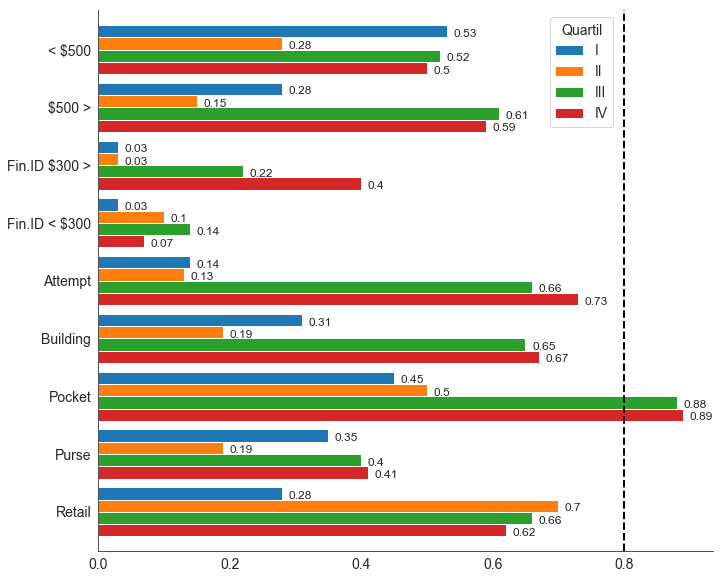

In [211]:
## barplot R2 of all thefts and quartiles

# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "14"
# plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'monospace'
    
    
dfTestR2.columns = ['I', 'II', 'III', 'IV']
dfTestR2.index = ['< $500',
 'Attempt',
 'Fin.ID $300 >',
 'Fin.ID < $300',
 'Building',
 '$500 >',
 'Pocket',
 'Purse',
 'Retail']

dfTestR2 = dfTestR2.reindex(['< $500',
 '$500 >',
 'Fin.ID $300 >',
 'Fin.ID < $300',
 'Attempt',
 'Building',
 'Pocket',
 'Purse',
 'Retail'])

dfTestR2 = np.round(dfTestR2, 2)

# ax = dfTestR2.plot.barh(xlim=(0.0, 1), figsize=(10,8))
# ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.axvline(x=0.80, linewidth=3, color='k', ls='--')
# plt.tight_layout(pad=0.4)
# plt.gca().invert_yaxis()

sns.set_style("white") #for aesthetic purpose only

ax = dfTestR2.plot(kind='barh',width=0.85, figsize=(10,8))
ax.axvline(x=0.80, linewidth=2, color='k', ls='--')

plt.gca().invert_yaxis()

idx = 0
idy = 0
c = 0
for r in ax.patches:
    xpos = r.get_width()
    ypos = r.get_y()    
    ax.text(xpos+0.01, ypos+0.2, dfTestR2.T.values.flatten()[c], fontsize=12
#             , family="monospace"
           )
    c = c + 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Quartil', bbox_to_anchor=(0.85, 1.0))
plt.tight_layout(pad=0.4)
plt.savefig("r2.PNG", dpi=600)



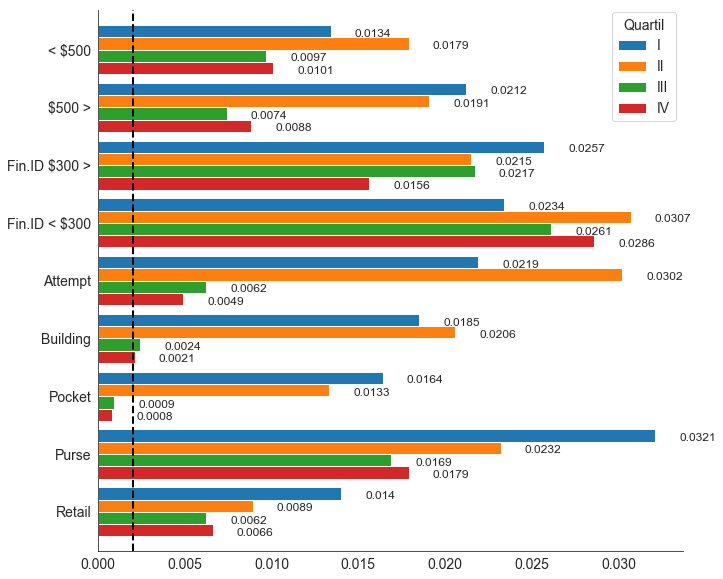

In [212]:
## barplot Mean Square Error of all thefts and quartiles
plt.rcParams["font.size"] = "14"
plt.rcParams['font.family'] = 'monospace'
    
dfTestEcm.columns = ['I', 'II', 'III', 'IV']
dfTestEcm.index = ['< $500',
 'Attempt',
 'Fin.ID $300 >',
 'Fin.ID < $300',
 'Building',
 '$500 >',
 'Pocket',
 'Purse',
 'Retail']

dfTestEcm = dfTestEcm.reindex(['< $500',
 '$500 >',
 'Fin.ID $300 >',
 'Fin.ID < $300',
 'Attempt',
 'Building',
 'Pocket',
 'Purse',
 'Retail'])

# ax = dfTestEcm.plot.barh(xlim=(0.0, 0.035), figsize=(10,8))
# ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)

# #removing top and right borders
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.axvline(x=0.002, linewidth=3, color='k', ls='--')
# plt.tight_layout(pad=0.4)
# plt.savefig("ecm.PNG", dpi=300)

sns.set_style("white") #for aesthetic purpose only

dfTestEcm = np.round(dfTestEcm, 4)

ax = dfTestEcm.plot(kind='barh',width=0.85, figsize=(10,8))
ax.axvline(x=0.002, linewidth=2, color='k', ls='--')

plt.gca().invert_yaxis()

idx = 0
idy = 0
c = 0
for r in ax.patches:
    xpos = r.get_width()
    ypos = r.get_y()    
    ax.text(xpos+0.0014, ypos+0.2, dfTestEcm.T.values.flatten()[c], fontsize=12
#             , family="monospace"
           )
    c = c + 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Quartil', bbox_to_anchor=(1, 1.01))
plt.tight_layout(pad=0.4)
plt.savefig("ecm.PNG", dpi=600)

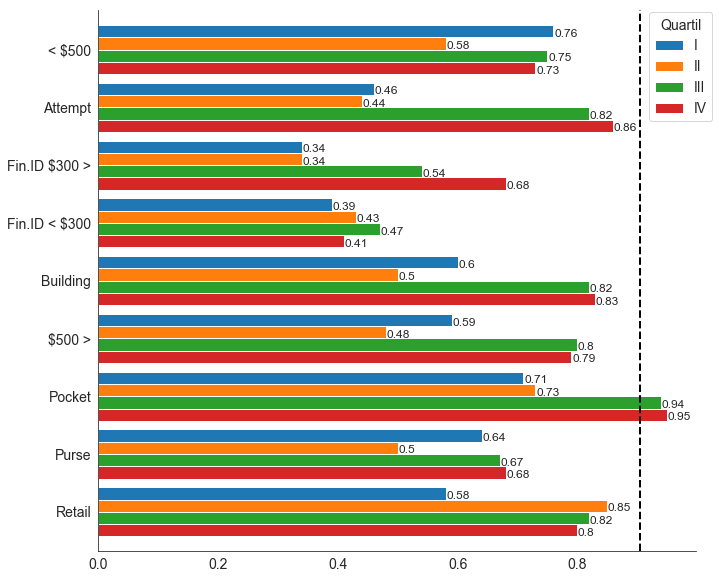

In [213]:
## barplot Correlation coefficent of all thefts and quartiles
dfTestCorrP.columns = ['I', 'II', 'III', 'IV']
dfTestCorrP.index = ['< $500',
 'Attempt',
 'Fin.ID $300 >',
 'Fin.ID < $300',
 'Building',
 '$500 >',
 'Pocket',
 'Purse',
 'Retail']
# y_pos = [0,1,5,8,9]


# ax = dfTestCorrP.plot.barh(xlim=(0.2, 1), figsize=(10,8))
# ax.legend(title='quartil', loc='center', bbox_to_anchor=(0.4, 1.1), ncol=4)
# # plt.yticks(y_pos, dfTestCorrP.index)

# #removing top and right borders
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.axvline(x=0.90, linewidth=3, color='k', ls='--')
# plt.tight_layout(pad=0.4)
# plt.savefig("pearson.PNG", dpi=300)

dfTestCorrP = np.round(dfTestCorrP, 2)

sns.set_style("white") #for aesthetic purpose only

ax = dfTestCorrP.plot(kind='barh',width=0.85, figsize=(10,8))
ax.axvline(x=0.905, linewidth=2, color='k', ls='--')

plt.gca().invert_yaxis()

idx = 0
idy = 0
c = 0
for r in ax.patches:
    xpos = r.get_width()
    ypos = r.get_y()    
    ax.text(xpos+0.001, ypos+0.2, dfTestCorrP.T.values.flatten()[c], fontsize=12
#             , family="monospace"
           )
    c = c + 1

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Quartil', bbox_to_anchor=(0.91, 1.01))
plt.tight_layout(pad=0.4)
plt.savefig("pearson.PNG", dpi=600)

################################################################
POCKET-PICKING


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


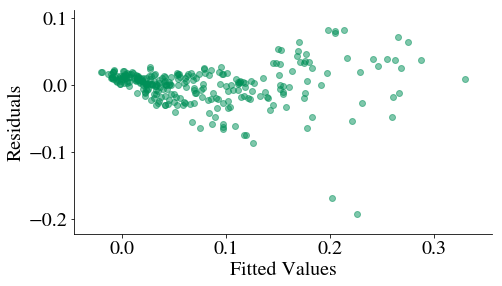

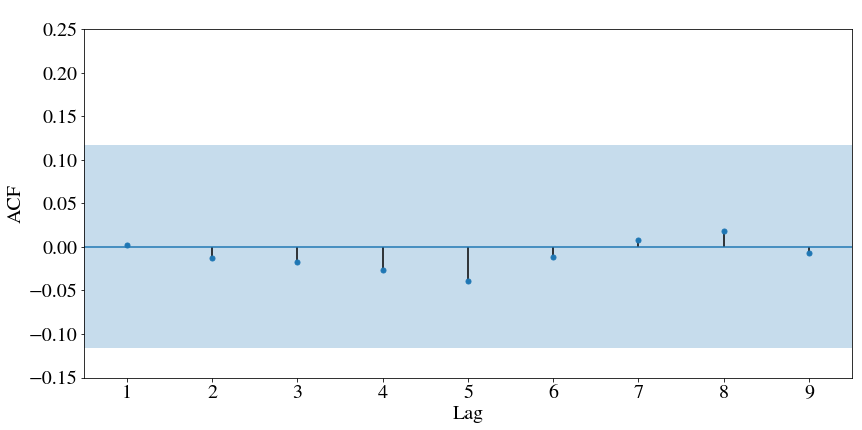

In [81]:
## Test model with a specific Theft 'POCKET-PICKING' and III and IV quartiles
ths = [
        '$500 AND UNDER', 'ATTEMPT THEFT','FINANCIAL ID THEFT: OVER $300',
       'FINANCIAL ID THEFT:$300 &UNDER', 'FROM BUILDING', 'OVER $500',
       'POCKET-PICKING', 'PURSE-SNATCHING', 'RETAIL THEFT'
    ]

ths = [
        '$500 AND UNDER', 
        'ATTEMPT THEFT',
        'POCKET-PICKING', 
        'PURSE-SNATCHING'
    ]

for th in ['POCKET-PICKING']:
    print('################################################################') 
    print(th)

    df2 = prepare_df2(th, dbTH, df1)
    df2 = df2[df2[th] > 0]
    ix = outliers_thefts(df2, th)
    df2 = df2[ix]
    
    qs = df2[[th]].quantile([.25, .5, .75, 1]).values
    for q in [2]:
        df3 = df2[((df2[[th]] >= qs[2]) & (df2[[th]] <= qs[3])).values]
        ths1 = [m for m in ths if m != th]
        d = np.sum(df3[th].values)/np.sum(df3[ths1].sum(axis=0).values)
        di = df3[th]/df3[ths1].sum(axis=1)
        L = di/d
        C = df3[th]/df3[['boardings', 'alightings']].sum(axis=1)
        dft = pd.concat([ df3[[
                            'betweenness_centrality', 
                            'boardings', 'alightings']],
                            L,
                            C,
                            df3[ths]
                        ], axis=1, sort=True)
        dft = dft.rename(columns = {0:'L', 1: 'C'})

        dft = norm_df(dft)

        train, test = sklearn.model_selection.train_test_split(dft, train_size = .7)
        
        train = train[outliers_thefts(train, th)].dropna()
        test = test[outliers_thefts(test, th)].dropna()
        
        olsres = compute_ols(train, th)
#         fitted_vals = Homoscedasticity_test1(olsres, test, q, th) 
        
    
        # Graphic test 
        ## Compute predictions and residuals
        fitted_vals = olsres.predict()
        resids = olsres.resid
        Xnew = test.drop([th], axis=1)
        X_constant1 = sm.add_constant(Xnew)
        y_true = test[th]
        ynewpred =  olsres.predict(X_constant1)

        ## Init plots
        colors = ['#2300A8', '#009058']
        fig, ax = plt.subplots(figsize=(7, 4))

        ### Plot 0. residuals and data
        ax.scatter(
            x=fitted_vals, 
            y=resids, 
            label="Data", 
            alpha=0.50, 
            color=colors[1])
        ### Plot 0. Configurations
#         ax.set_title(th)
        ax.set(
            xlabel='Fitted Values', 
            ylabel='Residuals')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.tight_layout(pad=0.4)
        plt.savefig("test1_POCKET-PICKING.PNG", dpi=600)
        

        import statsmodels.tsa.api as smt

        N, M = 12, 6
        fig, ax = plt.subplots(figsize=(N, M))
        smt.graphics.plot_pacf(fitted_vals, lags = 15, title=' ', ax=ax)
        ax.set_ylim(-0.15, 0.25)
        ax.set_xlim(0.5, 9.5)
        ax.set(
            xlabel='Lag', 
            ylabel='ACF')        
        plt.tight_layout(pad=0.4)
        plt.savefig("ACF.png", dpi=600)       
        
        
        
#         Multicollinearity_test2(train, th)
#         NoAutoCorrelation_test3(fitted_vals)
        
#         from scipy.stats.stats import pearsonr
#         print(np.square(np.subtract(train[th], fitted_vals)).mean())        
#         print(pearsonr(train[th], fitted_vals)[0])        
        
#         print(th + ' Q=' + str(q+1))    
#         print('################################################################')


OLS: 0.749141 (0.207763)
OLS: -0.001277 (0.001193)
NN: -0.396614 (1.706915)
NN: -0.005547 (0.003308)
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


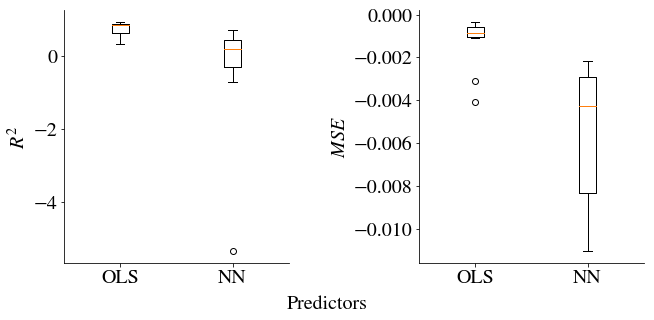

In [80]:
## Test different predictors
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

X = test.drop([th], axis=1)
Y = test[th]

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('LR', LogisticRegression()))

models.append(('OLS', LinearRegression()))
models.append(('NN', MLPRegressor()))
# models.append(('KNN', KNeighborsClassifier()))
# # models.append(('DT', DecisionTreeClassifier()))
# # models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

from sklearn.metrics import r2_score

# evaluate each model in turn
resultsR2 = []
namesR2 = []

resultsMSE = []
namesMSE = []

scoring = ['r2', 'neg_mean_squared_error']
for name, model in models:
        
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
#     cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    cv_results = model_selection.cross_validate(model, X, Y, cv=kfold, scoring=scoring)
    
    resultsR2.append(cv_results['test_r2'])
    namesR2.append(name)
    
    resultsMSE.append(cv_results['test_neg_mean_squared_error'])
    namesMSE.append(name)    
    
    msg = "%s: %f (%f)" % (name, cv_results['test_r2'].mean(), cv_results['test_r2'].std())
    print(msg)
    msg = "%s: %f (%f)" % (name, cv_results['test_neg_mean_squared_error'].mean(), cv_results['test_neg_mean_squared_error'].std())
    print(msg)

    
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
    
# boxplot algorithm comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].boxplot(resultsR2)
ax[0].set_xticklabels(namesR2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel(r'$R^2$')


ax[1].boxplot(resultsMSE)
ax[1].set_xticklabels(namesMSE)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylabel(r'$MSE$')

fig.text(0.5, 0.05, 'Predictors', ha='center')

fig.tight_layout(pad=2.0)

plt.savefig("predictors.PNG", dpi=600)
print(model)


In [ ]:
## Test different predictors - scatter plots
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.stats.stats import pearsonr

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

X = train.drop([th], axis=1)
Y = train[th]

# fit a CART model to the data
model = MLPRegressor()
model.fit(X, Y)
print(); print(model)

# make predictions
expected_y  = test[th]
predicted_y = model.predict(test.drop([th], axis=1))

print("ANN")
print("R2 = ", end='')
print(metrics.r2_score(expected_y, predicted_y))
print("MSE = ", end='')
print(np.square(np.subtract(expected_y, predicted_y)).mean())
print("Correlation coef = ", end='')
print(np.square(pearsonr(expected_y, predicted_y)[0]))

ax[0].scatter(y_true, predicted_y)
ax[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'gray', lw=1)
ax[0].fill_between(xplt, xplt-np.std(xplt), xplt+np.std(xplt), color='gray', alpha=0.2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
# ax[0].set_ylabel('Predictions')
# ax[0].set_xlabel('Expected')
ax[0].set_title('Neural network')




fitted_vals = olsres.predict()
resids = olsres.resid
Xnew = test.drop([th], axis=1)
X_constant1 = sm.add_constant(Xnew)
y_true = test[th]
ynewpred =  olsres.predict(X_constant1)

xplt = np.linspace(y_true.min(), y_true.max(), 1000)
      
print("OLS")
print("R2 = ", end='')
print(metrics.r2_score(y_true, ynewpred))
print("MSE = ", end='')
print(np.square(np.subtract(y_true, ynewpred)).mean())
print("Correlation coef = ", end='')
print(np.square(pearsonr(y_true, ynewpred)[0]))

ax[1].scatter(y_true, ynewpred)
ax[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'gray', lw=1)
ax[1].fill_between(xplt, xplt-np.std(xplt), xplt+np.std(xplt), color='gray', alpha=0.2)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_ylabel('Predictions')
ax[1].set_xlabel('')
ax[1].set_title('Linear')

fig.text(0.5, -0.05, 'Expected', ha='center')
fig.text(0.04, 0.5, 'Predictions', va='center', rotation='vertical')

In [19]:
## Plot bus stop distribution map
lat = dbXY.loc[df3.index.values].POINT_Y.values
lon = dbXY.loc[df3.index.values].POINT_X.values

m = folium.Map(location=[lat[0], lon[0]], 
               zoom_start=11,
               prefer_canvas=True,
               control_scale=True,
               zoom_control=False
              )

for lati, loni, nami in zip(lat,lon,df3.index.values):
#     folium.Marker([lati, loni], popup="Bus stop #" + str(nami)).add_to(m)
    folium.CircleMarker(location=[lati,loni],
                        popup="Bus stop #" + str(nami),
                        color='black',
                        radius=1,
                        weight=1).add_to(m)
# display(m)
m.save("map.html")

In [21]:
## Draw boundaries of RoI in map
print(min(lon), max(lon), min(lat), max(lat))

m = folium.Map(location=[lat[0], lon[0]], 
               zoom_start=11,
               prefer_canvas=True,
               control_scale=True,
               zoom_control=False
              )

folium.CircleMarker(location=[41.69, -87.76],
                    popup="Bus stop #" + str(nami),
                    color='red',
                    radius=4,
                    weight=8).add_to(m)
folium.CircleMarker(location=[42.02, -87.76],
                    popup="Bus stop #" + str(nami),
                    color='red',
                    radius=4,
                    weight=8).add_to(m)
folium.CircleMarker(location=[41.69, -87.55],
                    popup="Bus stop #" + str(nami),
                    color='red',
                    radius=4,
                    weight=8).add_to(m)
folium.CircleMarker(location=[42.02, -87.55],
                    popup="Bus stop #" + str(nami),
                    color='red',
                    radius=4,
                    weight=8).add_to(m)
folium.PolyLine([[41.69, -87.76], [42.02, -87.76], [42.02, -87.55],[41.69, -87.55], [41.69, -87.76]]).add_to(m)

for lati, loni, nami in zip(lat,lon,df3.index.values):
#     folium.Marker([lati, loni], popup="Bus stop #" + str(nami)).add_to(m)
    folium.CircleMarker(location=[lati,loni],
                        popup="Bus stop #" + str(nami),
                        color='black',
                        radius=1,
                        weight=2).add_to(m)
display(m)
m.save("map.html")

-87.76886033 -87.55117558 41.689070799999996 42.01611703


In [42]:
## Adjust image and scatter
import matplotlib.image as mpimg
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def adjust_BBox(
    y_mean=(-0.01, 0.01, 0.005),
    y_zoom=(-0.01, 0.01, 0.005),
    
    x_mean=(-0.01, 0.01, 0.0005),
    x_zoom=(-0.01, 0.01, 0.0005)
               ):
    print("min(lon)+" + str(x_zoom+x_mean) +
          ", max(lon)+" + str(-x_zoom+x_mean) +
          ", min(lat)+" + str(-y_zoom+y_mean) + 
          ", max(lat)+" + str(y_zoom+y_mean) )
#     0.001 0.0185  0.061 0.0575
#     BBox = (min(lon)-0.1185, max(lon)+0.00345, min(lat)+0.0175, max(lat)+0.0195)
    BBox = (
        min(lon)+x_zoom+x_mean, 
        max(lon)-x_zoom+x_mean, 
        min(lat)-y_zoom+y_mean, 
        max(lat)+y_zoom+y_mean)
    img = mpimg.imread('.//mapa.PNG')


    fig, ax = plt.subplots(figsize = (10,15))
    ax.scatter(lon, lat, zorder=1, alpha= 1.0, c='r', s=10)
    ax.imshow(img, zorder=0, extent = BBox, aspect= 'auto')

    ax.set_xlim(BBox[0], BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    
    return ax

interactive(children=(FloatSlider(value=0.0, description='y_mean', max=0.01, min=-0.01, step=0.005), FloatSlid…

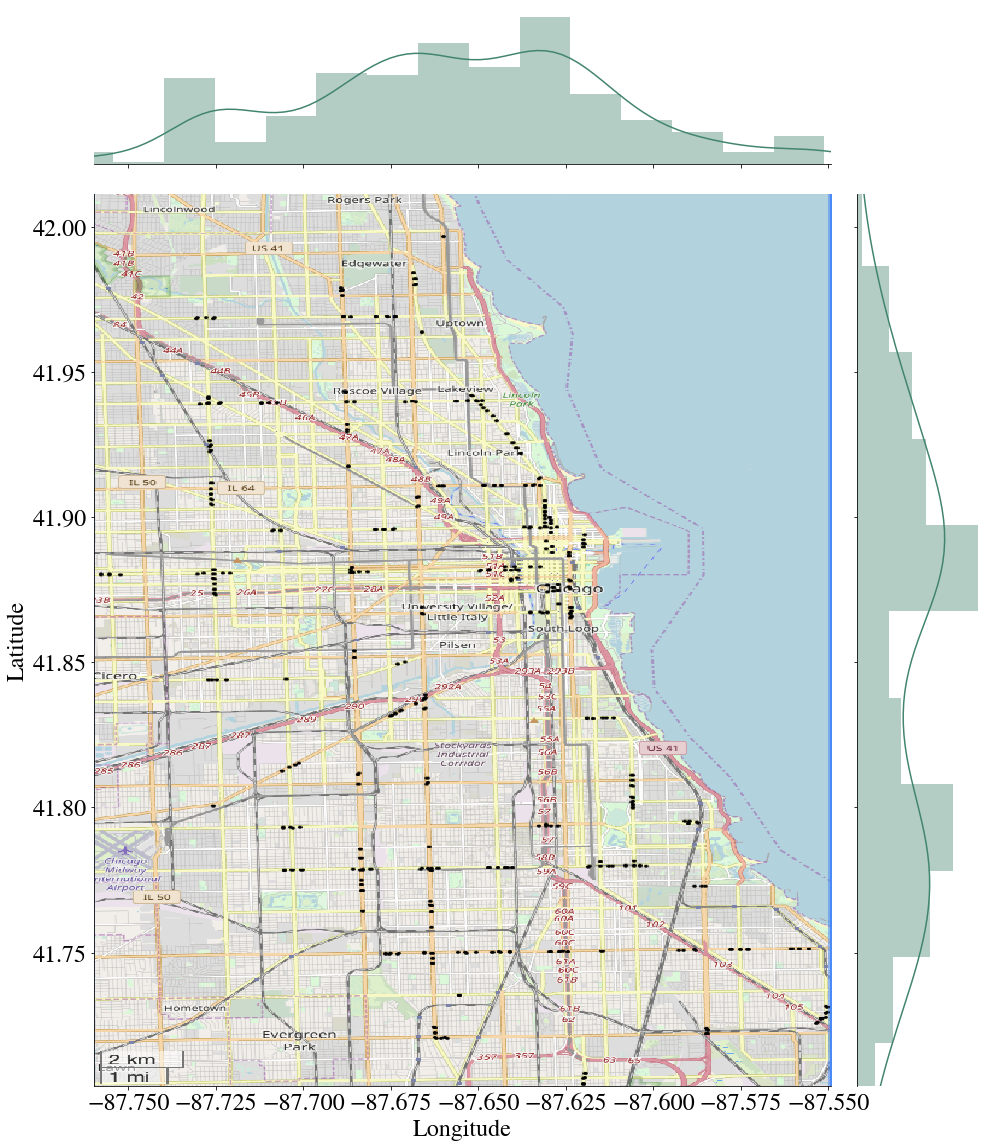

In [58]:
## Plot distribution over map
import seaborn as sns
import matplotlib.pyplot as plt

lat = dbXY.loc[df3.index.values].POINT_Y.values
lon = dbXY.loc[df3.index.values].POINT_X.values
dfT = pd.DataFrame([lat, lon]).T
dfT.columns = ['Latitude', 'Longitude']

BBox = (
    min(lon)+0.009, max(lon)+0.002, min(lat)+0.015, max(lat)-0.005
)
img = mpimg.imread('.//mapa.PNG')

g = sns.JointGrid(y='Latitude', x='Longitude', data=dfT)
g = g.plot_joint(plt.scatter, zorder=1, alpha= 0.0, s=10, color='#334f6d')

plt.imshow(img, zorder=0, extent = BBox, aspect= 'auto')
g = g.plot_marginals(sns.distplot, color='#418470')

g.fig.set_size_inches(17, 20)
g.ax_marg_y.set_ylim(BBox[2],BBox[3])
g.ax_marg_x.set_xlim(BBox[0], BBox[1]);

plt.savefig("map1.PNG", dpi=600)